# UNET NETWORK (TGS Salt Identification Challenge)

## 1. Import packages

**Import necessary packages and modules**

In [1]:
import os
import time
import datetime
import string
import random
import math
import json
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
import progressbar
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
print(os.listdir("../input"))

['sample_submission.csv', 'depths.csv', 'test', 'train.csv', 'train', 'README.md', '.ipynb_checkpoints']


**Set the random seed of numpy and tensorflow**

In [2]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 56
tf_rand_seed = 62
np.random.seed(np_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  56
tensorflow random seed:  62


## 2. Create Utility Functions

In [3]:
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


def masks_as_image(in_mask_list):
    '''
    Take the individual ship masks and create a mask array for all ships
    '''
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks


def rle_encode_multimage(masks):
    '''
    A function to encode multiples image masks
    '''
    encoded_images = []
    for mask in masks:
        encoded_images.append(rle_encode(mask))
    return encoded_images


def binirize_mask(masks, threshold = 0.5):
    '''
    A function to binirize mask
    '''
    # iterate through each mask
    for n in range(masks.shape[0]):
        # binirize mask
        masks[n] = np.where(masks[n]>threshold, 1, 0)
    # return processed masks
    return masks


def resize_image(images, HEIGHT, WIDTH):

    '''
    A function to resize a batch of images
    '''
    # ignore warning
    import warnings
    warnings.filterwarnings('ignore')

    batch_size = images.shape[0]
    IMG_CHANNELS = images.shape[3]
    # numpy array to store the resized images
    X = np.zeros((batch_size, HEIGHT, WIDTH, IMG_CHANNELS), dtype=np.float32)

    # iterate and resize each image
    for n, img in enumerate(images):
        X[n] = resize(img, (HEIGHT, WIDTH), mode='constant', preserve_range=True)

    return X


def compute_iou_np(A, B):
    '''
    A function to compute IoU in given
    batches of masks A and predicted masks B in numpy arrays
    '''
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)

        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue

        # non empty mask case.  Union is never empty
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union

        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10

        metric += iou

    # teake the average over all images in batch
    metric /= batch_size
    return metric


def generate_batch(indices, ids, IMG_DIR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, 
                   MAX, train_set = False, display = False):
    
    '''
    A function to generate train/test image batch
    '''
    # ignore warning
    import warnings
    warnings.filterwarnings('ignore')
    
    # extract the id based of train/test set
    batch_ids = ids[indices]
    
    # initialize numpy arrays to hold images and masks 
    X = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    Y = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    
    # iterate through each image
    for n, id_ in enumerate(batch_ids):        
        # construct path for the image
        if train_set:
            img_path = IMG_DIR+"/images/"+id_+".png"
        else:
            img_path = IMG_DIR+"/images/"+id_
        # load image 
        img = imread(img_path)
        # resize image
        if img.shape[0] != IMG_HEIGHT or img.shape[0] != IMG_WIDTH: 
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        # if we are using image for training and testing then 
        if not display:
            img = img/255.0
        # store the image in the designated numpy array
        X[n] = img.astype(np.float32)
        # del image to save runtime memory
        del(img)
        # if train set is wanted
        if train_set:
            mask_path = IMG_DIR+"/masks/"+id_+".png"
            # extract mask
            mask = imread(mask_path, as_gray=True)
            # divide the mask by maximum value
            mask = mask/MAX
            # ceil the mask
            mask = np.ceil(mask)
            # resize mask
            if mask.shape[0] != IMG_HEIGHT or mask.shape[1] != IMG_WIDTH: 
                mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            # expand dimension
            mask = np.expand_dims(mask, axis=-1)
            # store in the the designated numpy array
            Y[n] = mask.astype(np.float32)
            # delete mask to save runtime memory
            del(mask)

    if train_set:
        return X, Y
    else:
        return X
    

def mask_max_finder(ids, IMG_DIR):
    '''
    A funciton to find the maximum value of the mask
    '''
    maximum = 0
    for id_ in ids: 
        mask_path = IMG_DIR+"/masks/"+id_+".png"
        mask = imread(mask_path, as_gray=True)
        if mask.max()>maximum:
            maximum = mask.max()
    return maximum


## 3. Class module of U-Net Model

In [4]:
class unet(object):
    '''
    Class module of U-Net
    '''
    def __init__(self, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,IMG_HEIGHT_RESIZE,IMG_WIDTH_RESIZE,MASK_CHANNELS,
                conv_filters, conv_transpose_filters, kernel_sizes, strides,
                max_pool_kernel_size, max_pool_strides, learning_rate, device, tf_seed, np_seed, verbose = True):

        '''
        Class constructors which initializes the hyperparameters of U-Net
        '''
        # hyperparameters of the unet
        self.IMG_HEIGHT = IMG_HEIGHT
        self.IMG_WIDTH = IMG_WIDTH
        self.IMG_CHANNELS = IMG_CHANNELS
        self.IMG_HEIGHT_RESIZE = IMG_HEIGHT_RESIZE
        self.IMG_WIDTH_RESIZE = IMG_WIDTH_RESIZE
        self.MASK_CHANNELS = MASK_CHANNELS
        self.conv_filters = conv_filters
        self.conv_transpose_filters = conv_transpose_filters
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        self.max_pool_kernel_size = max_pool_kernel_size
        self.max_pool_strides = max_pool_strides
        self.learning_rate = learning_rate
        self.device = device
        self.tf_seed = tf_seed
        self.np_seed = np_seed
        self.verbose = verbose

        # placeholders and operations of the U-Net
        self.X = None
        self.Y = None
        self.Y_ = None
        self.cond = None
        self.training = None
        self.iou = None
        self.cost = None
        self.train_step = None

        # create graph of U-UNET
        self.X, self.Y, self.Y_, self.cond, self.training,\
        self.iou, self.cost, self.train_step = self.create_model()

        # training parameters
        self.saver = None
        self.train_cost = None
        self.valid_cost = None
        self.best_cost = None
        self.best_iteration = None
        self.best_time = None
        self.log_of_computation_time = []


    def intersection_of_union(self, label, pred):
        '''
        A function to compute iou in tensorflow
        '''
        return tf.py_func(compute_iou_np, [label, pred > 0.5], tf.float64)


    def create_model(self):
        '''
        A method to create graph of U-Net
        '''
        # placeholder to decide to apply a particular augmentation or not
        cond = tf.placeholder(tf.int32, shape=(3,))
        # placeholder of input image
        X = tf.placeholder(tf.float32, [None, self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS])
        # resize input image
        if self.IMG_HEIGHT != self.IMG_HEIGHT_RESIZE or self.IMG_WIDTH != self.IMG_WIDTH_RESIZE:
            X_RESIZED = tf.image.resize_images(X, size=[self.IMG_HEIGHT_RESIZE, self.IMG_WIDTH_RESIZE])
        else:
            X_RESIZED = tf.identity(X)
        # randomly flip up & down, left & right, and rotate 90
        X_RESIZED = tf.cond(cond[0] > 0, lambda: tf.image.flip_up_down(X_RESIZED), lambda: X_RESIZED)
        X_RESIZED = tf.cond(cond[1] > 0, lambda: tf.image.flip_left_right(X_RESIZED), lambda: X_RESIZED)
        X_RESIZED = tf.cond(cond[2] > 0, lambda: tf.image.rot90(X_RESIZED), lambda: X_RESIZED)
        # placeholder of mask
        Y = tf.placeholder(tf.float32, [None, self.IMG_HEIGHT, self.IMG_WIDTH, self.MASK_CHANNELS])
        # resize output mask
        if self.IMG_HEIGHT != self.IMG_HEIGHT_RESIZE or self.IMG_WIDTH != self.IMG_WIDTH_RESIZE:
            Y_RESIZED = tf.image.resize_images(Y, size=[self.IMG_HEIGHT_RESIZE, self.IMG_WIDTH_RESIZE])
        else:
            Y_RESIZED = tf.identity(Y)
        # randomly flip up & down, left & right, and rotate 90
        Y_RESIZED = tf.cond(cond[0] > 0, lambda: tf.image.flip_up_down(Y_RESIZED), lambda: Y_RESIZED)
        Y_RESIZED = tf.cond(cond[1] > 0, lambda: tf.image.flip_left_right(Y_RESIZED), lambda: Y_RESIZED)
        Y_RESIZED = tf.cond(cond[2] > 0, lambda: tf.image.rot90(Y_RESIZED), lambda: Y_RESIZED)
        # placeholder for mode of batch normalization
        training = tf.placeholder(tf.bool)
        # a list to store the convolutional layers
        convs = []

        if self.verbose:
            print("########################Layers of UNET########################")

        # create convolutational layers of U-Net using a for loop
        for n, conv_filter in enumerate(self.conv_filters):
            # if it is the 1st convolutional layer
            if n == 0:
                with tf.device(self.device):
                    # conv layer
                    conv = tf.layers.conv2d(X_RESIZED, filters=conv_filter//2, kernel_size=self.kernel_sizes[n],
                                            strides=[self.strides,self.strides],
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            padding="SAME")
                    if self.verbose:
                        print(conv)
                    # activation layer
                    conv = tf.nn.elu(conv)
                    if self.verbose:
                        print(conv)
                    # batch normalization layer
                    conv = tf.layers.batch_normalization(conv, training=training)
                    if self.verbose:
                        print(conv)
                    # conv layer
                    conv = tf.layers.conv2d(conv, filters=conv_filter//2, kernel_size=self.kernel_sizes[n],
                                            strides=[self.strides,self.strides],
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            padding="SAME")
                    if self.verbose:
                        print(conv)
                    # activation layer
                    conv = tf.nn.elu(conv)
                    if self.verbose:
                        print(conv)
                    # batch normalization layer
                    conv = tf.layers.batch_normalization(conv, training=training)
                    if self.verbose:
                        print(conv)
                    # append the layer to the designated list
                    convs.append(tf.identity(conv))
                    # max pooling layer
                    conv = tf.layers.max_pooling2d(conv, self.max_pool_kernel_size,
                                                self.max_pool_strides, padding='SAME')
                    if self.verbose:
                        print(conv)
            # for rest of the layers
            else:
                with tf.device(self.device):
                    # conv layer
                    conv = tf.layers.conv2d(conv, filters=conv_filter//2, kernel_size=self.kernel_sizes[n],
                                            strides=[self.strides,self.strides],
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            padding="SAME")
                    if self.verbose:
                        print(conv)
                    # activation layer
                    conv = tf.nn.elu(conv)
                    if self.verbose:
                        print(conv)
                    # batch normalization layer
                    conv = tf.layers.batch_normalization(conv, training=training)
                    if self.verbose:
                        print(conv)
                    # conv layer
                    conv = tf.layers.conv2d(conv, filters=conv_filter//2, kernel_size=self.kernel_sizes[n],
                                            strides=[self.strides,self.strides],
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            padding="SAME")
                    if self.verbose:
                        print(conv)
                    # activation layer
                    conv = tf.nn.elu(conv)
                    if self.verbose:
                        print(conv)
                    # batch normalization layer
                    conv = tf.layers.batch_normalization(conv, training=training)
                    if self.verbose:
                        print(conv)
                    # append the layer to the designated list
                    convs.append(tf.identity(conv))
                    # max pooling layer
                    conv = tf.layers.max_pooling2d(conv, self.max_pool_kernel_size, 
                                                   self.max_pool_strides, padding='SAME')
                    if self.verbose:
                        print(conv)

        # create deconvolutational layers of UNET using a for loop
        for n, conv_transpose_filter in enumerate(self.conv_transpose_filters):
            # if it is not the last layer
            if n != len(self.conv_transpose_filters)-1:
                with tf.device(self.device):
                    # deconvolutional layer
                    conv = tf.layers.conv2d_transpose(conv, filters=conv_transpose_filter,
                                                        kernel_size=self.kernel_sizes[::-1][n],
                                                        kernel_initializer=tf.variance_scaling_initializer(),
                                                        strides=[2,2], padding="SAME")
                    if self.verbose:
                        print(conv)
                    # activation layer
                    conv = tf.nn.elu(conv)
                    if self.verbose:
                        print(conv)
                    # batch normalization layer
                    conv = tf.layers.batch_normalization(conv, training=training)
                    if self.verbose:
                        print(conv)
                    # concat the corresponding convolutional layer (this improves accuracy)
                    conv = tf.concat((conv, convs[::-1][n]), axis=3)
                    if self.verbose:
                        print(conv)
                    # convolutional layer of concatenation
                    conv = tf.layers.conv2d(conv, filters=conv_transpose_filter//2,
                                            kernel_size=self.kernel_sizes[::-1][n],
                                            strides=[self.strides,self.strides],
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            padding="SAME")
                    if self.verbose:
                        print(conv)
                    # activation layer
                    conv = tf.nn.elu(conv)
                    if self.verbose:
                        print(conv)
                    # batch normalization
                    conv = tf.layers.batch_normalization(conv, training=training)
                    if self.verbose:
                        print(conv)
            # if it is the last layer
            else:
                with tf.device(self.device):
                    # transposed convolutional layer
                    conv = tf.layers.conv2d_transpose(conv, filters=conv_transpose_filter,
                                                      kernel_size=self.kernel_sizes[::-1][n],
                                                      kernel_initializer=tf.variance_scaling_initializer(),
                                                      strides=[2,2], padding="SAME")
                    if self.verbose:
                        print(conv)
                    # activation layer
                    conv = tf.nn.elu(conv)
                    if self.verbose:
                        print(conv)
                    # batch normalization
                    conv = tf.layers.batch_normalization(conv, training=training)
                    if self.verbose:
                        print(conv)
                    # concat the corresponding convolutional layer (this improves accuracy)
                    conv = tf.concat((conv, convs[::-1][n]), axis=3)
                    if self.verbose:
                        print(conv)
                    # convolutional layer of concatenation
                    conv = tf.layers.conv2d(conv, filters=conv_transpose_filter//2,
                                            kernel_size=self.kernel_sizes[::-1][n],
                                            strides=[self.strides,self.strides],
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            padding="SAME")
                    if self.verbose:
                        print(conv)
                    # activation layer
                    conv = tf.nn.elu(conv)
                    if self.verbose:
                        print(conv)
                    # batch normalization
                    conv = tf.layers.batch_normalization(conv, training=training)
                    if self.verbose:
                        print(conv)
                    # convolutional layer of concatenation
                    out = tf.layers.conv2d(conv, filters=self.MASK_CHANNELS,
                                            kernel_size=self.kernel_sizes[::-1][n],
                                            strides=[self.strides,self.strides],
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            padding="SAME")
                    if self.verbose:
                        print(out)

        if self.verbose:
            print("#############################################################")

        with tf.device(self.device):
            # sigmoid of the last deconvolutional layer
            Y__ORIGINAL = tf.nn.sigmoid(out)
            # flatten the mask
            flat_y = tf.layers.Flatten()(Y_RESIZED)
            # flatten the predicted mask
            flat_y_ = tf.layers.Flatten()(Y__ORIGINAL)

        # resize predicted mask to size of original image
        if self.IMG_HEIGHT != self.IMG_HEIGHT_RESIZE or self.IMG_WIDTH != self.IMG_WIDTH_RESIZE:
            Y_ = tf.image.resize_images(Y__ORIGINAL, size=[self.IMG_HEIGHT, self.IMG_WIDTH])
        else:
            Y_ = Y__ORIGINAL

        # rounding predicted mask
        Y_ = tf.round(Y_)

        # compute iou
        iou = self.intersection_of_union(Y,Y_)

        with tf.device(self.device):
            # sigmoid_cross_entropy
            cost = tf.losses.sigmoid_cross_entropy(multi_class_labels=flat_y, logits=flat_y_)

        # optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        # update operation
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        with tf.control_dependencies(update_ops):
            with tf.device(self.device):
                # train step
                train_step = optimizer.minimize(cost)

        # store the placeholders in class fields
        return X, Y, Y_, cond, training, iou, cost, train_step


    def train_model(self, max_iter,batch_size,
                    train_indices,validation_indices,train_ids,
                    model_dir, model_name, generate_batch,*args):

        '''
        A function to train UNET network
        '''

        # create feed dict for validation
        image_validation, mask_validation =  generate_batch(validation_indices,*args,train_set=True)
        feed_dict_validation =  {self.X: image_validation.astype(np.float32), 
                                 self.Y: mask_validation.astype(np.float32),
                                 self.training: False, 
                                 self.cond: np.array([0,0,0])}

        # start time
        start_time = time.time()
        # create a saver object
        saver = tf.train.Saver(max_to_keep=1)
        # lists to store the train cost, validation cost
        train_cost = []
        valid_cost = []
        # variables to store the best cost and best iteration
        # and the time to reach the lowest cost
        best_cost = 100
        best_iteration = None
        best_time = None
        # number of training data
        N = len(train_indices)
        # number of complete batches
        num_complete_mini_batches = math.floor(N/batch_size)
        # path of model saver object
        model_path = model_dir+model_name

        # create a graph session and optimize the network under it
        with tf.Session() as sess:

            # set random seed of tensorflow
            tf.set_random_seed(self.tf_seed)
            # set random seed of numpy
            np.random.seed(self.np_seed)
            # initialize global variables
            sess.run(tf.global_variables_initializer())

            # create an object of progress bar
            bar = progressbar.ProgressBar(maxval=max_iter, widgets=[
                '[',progressbar.Percentage(),']',
                progressbar.Bar(),
                '(',progressbar.DynamicMessage("train_cost"),')',
                '(',progressbar.DynamicMessage("valid_cost"),')',
                '(',progressbar.DynamicMessage("best_valid_cost"),')',
                '(',progressbar.DynamicMessage("time_elapsed"),'mins)'
            ])
            # start the progress bar
            bar.start()
            # counter variable to track the number of iterations
            counter = 0
            # iterate until maximum number of iterations is reached
            while True:
                # break out of the inner for loop if maximum number of iterations is reached
                if counter>=max_iter:
                    break
                # iterate through the mini batches
                for k in range(0, num_complete_mini_batches+1):
                    # if the mini batch is a complete batch
                    if k < num_complete_mini_batches:
                        batch_indices = train_indices[list(range(k * batch_size, k * batch_size + batch_size))]
                    # handling the end case when the last mini batch is less than the batch_size
                    elif N % batch_size != 0:
                        batch_indices = train_indices[list(range(num_complete_mini_batches * batch_size, N))]

                    # conditions for flip up & down and left & right
                    conditions = np.random.choice([0,1], size=3)
                    # generate images and masks for the batch
                    image_batch, mask_batch = generate_batch(batch_indices,*args,train_set=True)
                    # feed dict of the batch
                    feed_dict_batch =  {self.X: image_batch.astype(np.float32), self.Y: mask_batch.astype(np.float32),
                                        self.training: True, self.cond: conditions}
                    # execute optimization step
                    sess.run(self.train_step, feed_dict=feed_dict_batch)
                    # calculate temporary train cost and append it to the designated list
                    temp_train_cost = self.cost.eval(session=sess, feed_dict=feed_dict_batch)
                    train_cost.append(temp_train_cost)
                    # calculate temporary validation cost and append it to the designated list
                    temp_validation_cost = self.cost.eval(session=sess, feed_dict=feed_dict_validation)
                    valid_cost.append(temp_validation_cost)
                    # compute running time from start point
                    time_diff = (time.time()-start_time)/60
                    # append elapsed time to the designated list
                    self.log_of_computation_time.append(time_diff)
                    # if valid cost is better than best recorded so far then
                    # update the parameters of the best model and save the model
                    if temp_validation_cost < best_cost:
                        best_time = time_diff
                        best_cost = temp_validation_cost
                        best_iteration = counter+1
                        saver.save(sess, model_path, global_step = best_iteration)

                    # update the progress bar
                    bar.update(counter+1, train_cost = temp_train_cost, valid_cost = temp_validation_cost,
                               best_valid_cost = best_cost, time_elapsed = time_diff)
                    # increment counter variable
                    counter += 1
                    # break out of the inner for loop if maximum number of iterations is reached
                    if counter>=max_iter:
                        break
            # finish the progress bar
            bar.finish()

        # store the required variables, placeholders and operations in designated class fields
        self.saver = saver
        self.train_cost = train_cost
        self.valid_cost = valid_cost
        self.best_cost = best_cost
        self.best_iteration = best_iteration
        self.best_time = best_time


    def compute_predictions(self,model_path, n_folds,test_ids, TEST_IMG_DIR,
                            threshold, submission_dir, submission_file,
                            generate_batch, HEIGHT, WIDTH, *args):

        '''
        A function to create predictions and submission file
        '''
        submission_path = submission_dir + submission_file

        with tf.Session() as sess:

            # set random seed of tensorflow
            tf.set_random_seed(self.tf_seed)
            # restore the best model
            self.saver.restore(sess, model_path)
            # number of test samples
            n = len(test_ids)
            # step size of each fold
            step = n//n_folds
            # a list to store the encoded pixels
            EncodedPixels = []
            # create a progress bar object
            bar = progressbar.ProgressBar(maxval=n_folds, widgets=[
                            '[',progressbar.Percentage(),']',
                            progressbar.Bar(),
                            '(',progressbar.DynamicMessage("number_of_folds_completed"),')'
                        ])
            # start progress bat
            bar.start()

            # iterate through each fold
            for i in range(n_folds):
                # start and end indices of the fold
                if i != (n_folds-1):
                    start = (step*i)
                    end = (step*(i+1))
                else:
                    start = (step*i)
                    end = len(test_ids)

                # create array of indices
                indices = list(range(start, end))
                indices = np.array(indices)

                # generate batch of test data
                image_test_batch = generate_batch(indices,*args,train_set=False)
                # feed dict for test batch
                feed_dict_test =  {self.X: image_test_batch.astype(np.float32),
                                    self.training: False,
                                    self.cond: np.array([0,0,0])}
                # compute predicted masks
                mask_predicted = sess.run(self.Y_, feed_dict=feed_dict_test)
                # binirize masks
                mask_predicted = binirize_mask(mask_predicted, threshold=threshold)
                # encode masks
                EncodedPixels = rle_encode_multimage(mask_predicted)

                # save the predictions to the designated csv file
                if i == 0:
                    submission = pd.DataFrame({"id":test_ids[indices],"rle_mask": EncodedPixels},
                                              columns=["id","rle_mask"])
                    submission.id = submission.id.fillna('')
                    submission.to_csv(submission_path, header = True, index=False)
                else:
                    submission = pd.DataFrame({"id":test_ids[indices],"rle_mask": EncodedPixels},
                                              columns=["id","rle_mask"])
                    submission.id = submission.id.fillna('')
                    submission.to_csv(submission_path, mode='a', header = False, index=False)

                # update the progress bar
                bar.update(i+1, number_of_folds_completed = i+1)

            # finish the progress bar
            bar.finish()

## 4. Load data

**Set some directories**

In [5]:
# input directory
input_dir = '../input/'
# directories of train and test images
TRAIN_IMG_DIR = os.path.join(input_dir, 'train')
TEST_IMG_DIR = os.path.join(input_dir, 'test')
# directory of the model files
model_dir = './model_files/'
# directory of submission files
submission_dir = "./submission_files/"

**Inspect the masks of training set**

In [6]:
masks = pd.read_csv(os.path.join(input_dir, "train.csv"))
not_empty = pd.notna(masks.rle_mask)
print(not_empty.sum(), 'masks in', masks[not_empty].id.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.id.nunique(), 'total images')
masks.head(20)

2438 masks in 2438 images
1562 empty images in 4000 total images


,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...
5,782ae9b7e7,1 1815 1819 90 1920 81 2021 73 2122 64 2223 55...
6,9842f69f8d,NaN
7,aa94cfb806,1 28 102 28 203 29 304 30 405 32 506 33 607 34...
8,50d3073821,1 2121 9293 909
9,28f865caaa,NaN


**Extract ids of train images**

In [7]:
train_ids = masks.id.values
train_ids = np.array(train_ids)

**Extract ids of test images**

In [8]:
test_ids = os.listdir(TEST_IMG_DIR+"/images")
test_ids = np.array(test_ids)

In [9]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 128, 128, 3

## 5. Visualize sample images and corresponding masks

**Find the maximum of the training set masks**

In [10]:
MAX = mask_max_finder(train_ids, TRAIN_IMG_DIR)

**A function to plot sample images and masks from training set**

In [11]:
def plot_image_and_mask(indices):
    '''
    A function to plot sample images and masks
    '''
    X,Y = generate_batch(indices, train_ids, TRAIN_IMG_DIR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, 
                         MAX, train_set=True, display = True)
    Y_squeezed = np.squeeze(Y)
    matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
    plt.subplot(4,4,1)
    plt.title("Image")
    plt.imshow(X[0].astype(np.uint8))
    plt.subplot(4,4,1+4)
    plt.title("Mask")
    plt.imshow(Y_squeezed[0])
    plt.subplot(4,4,2)
    plt.title("Image")
    plt.imshow(X[1].astype(np.uint8))
    plt.subplot(4,4,2+4)
    plt.title("Mask")
    plt.imshow(Y_squeezed[1])
    plt.subplot(4,4,3)
    plt.title("Image")
    plt.imshow(X[2].astype(np.uint8))
    plt.subplot(4,4,3+4)
    plt.title("Mask")
    plt.imshow(Y_squeezed[2])
    plt.subplot(4,4,4)
    plt.title("Image")
    plt.imshow(X[3].astype(np.uint8))
    plt.subplot(4,4,4+4)
    plt.title("Mask")
    plt.imshow(Y_squeezed[3])
    plt.subplot(4,4,9)
    plt.title("Image")
    plt.imshow(X[4].astype(np.uint8))
    plt.subplot(4,4,1+12)
    plt.title("Mask")
    plt.imshow(Y_squeezed[4])
    plt.subplot(4,4,10)
    plt.title("Image")
    plt.imshow(X[5].astype(np.uint8))
    plt.subplot(4,4,2+12)
    plt.title("Mask")
    plt.imshow(Y_squeezed[5])
    plt.subplot(4,4,11)
    plt.title("Image")
    plt.imshow(X[6].astype(np.uint8))
    plt.subplot(4,4,3+12)
    plt.title("Mask")
    plt.imshow(Y_squeezed[6])
    plt.subplot(4,4,12)
    plt.title("Image")
    plt.imshow(X[7].astype(np.uint8))
    plt.subplot(4,4,4+12)
    plt.title("Mask")
    plt.imshow(Y_squeezed[7])
    plt.show()

**Generate random indices and plot sample images and masks**

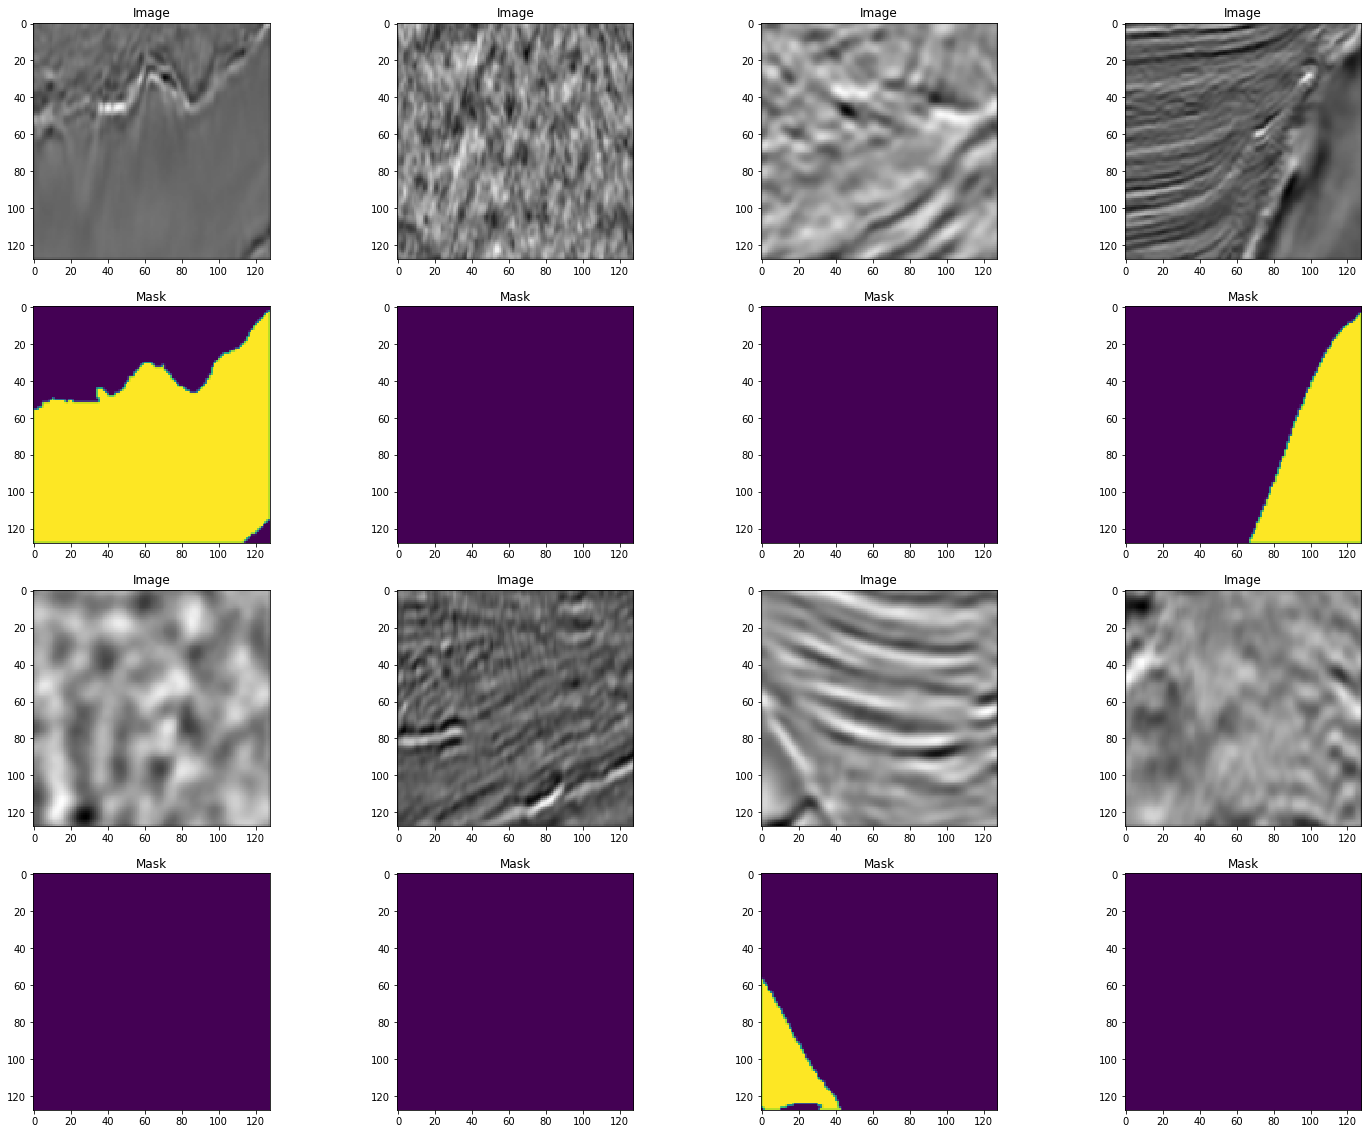

In [12]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

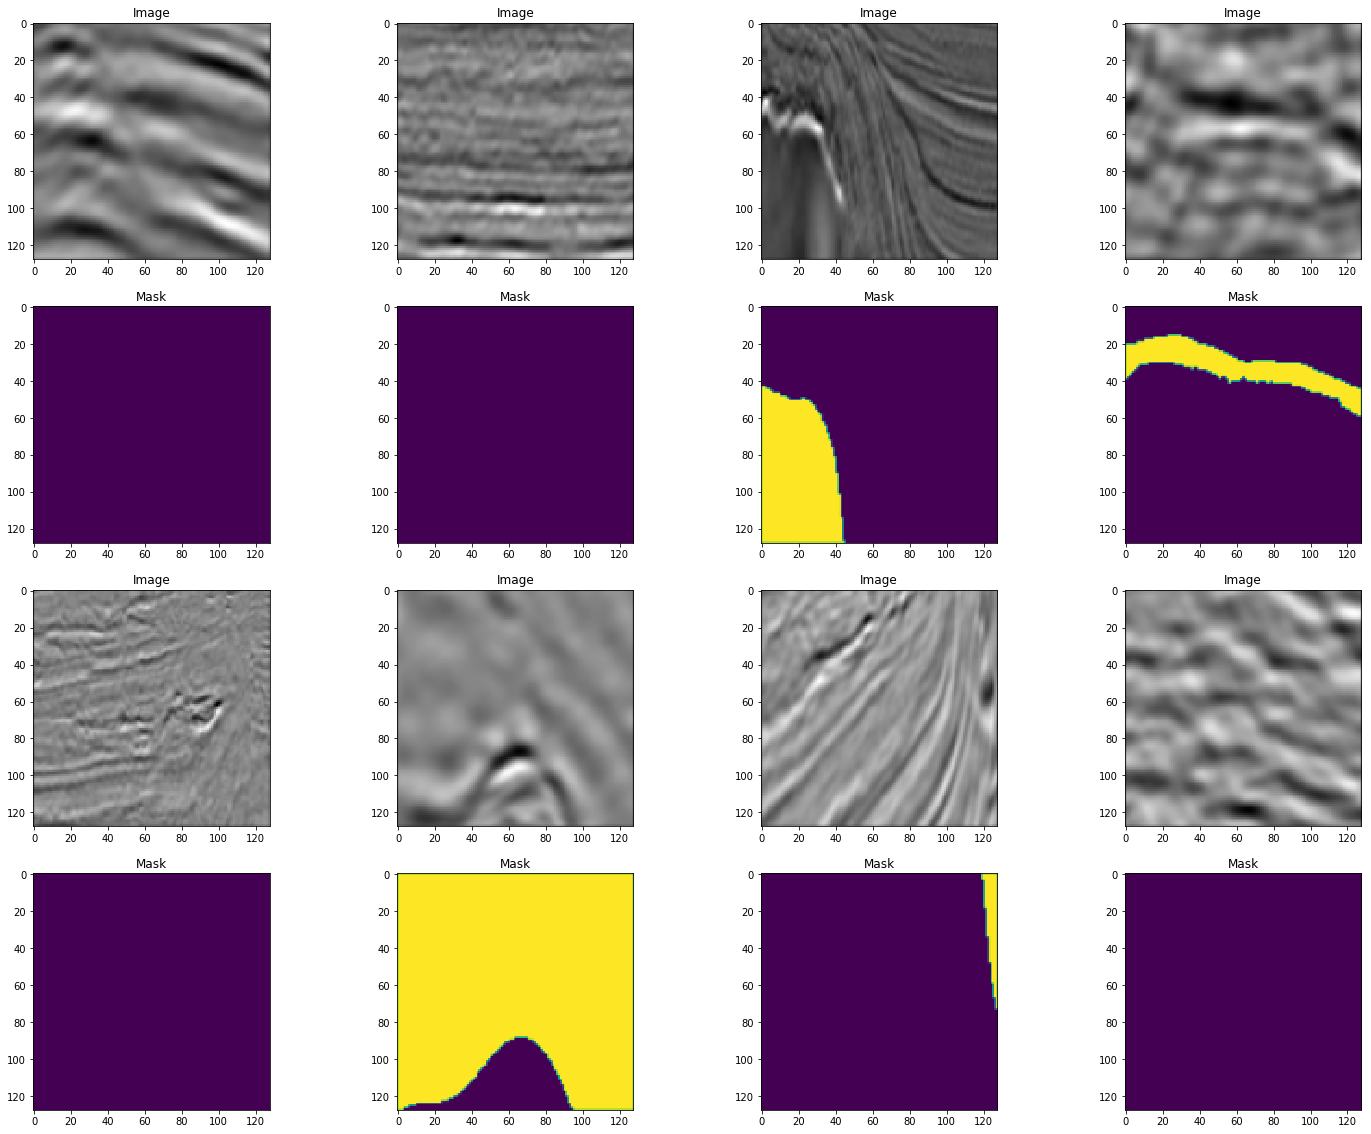

In [13]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

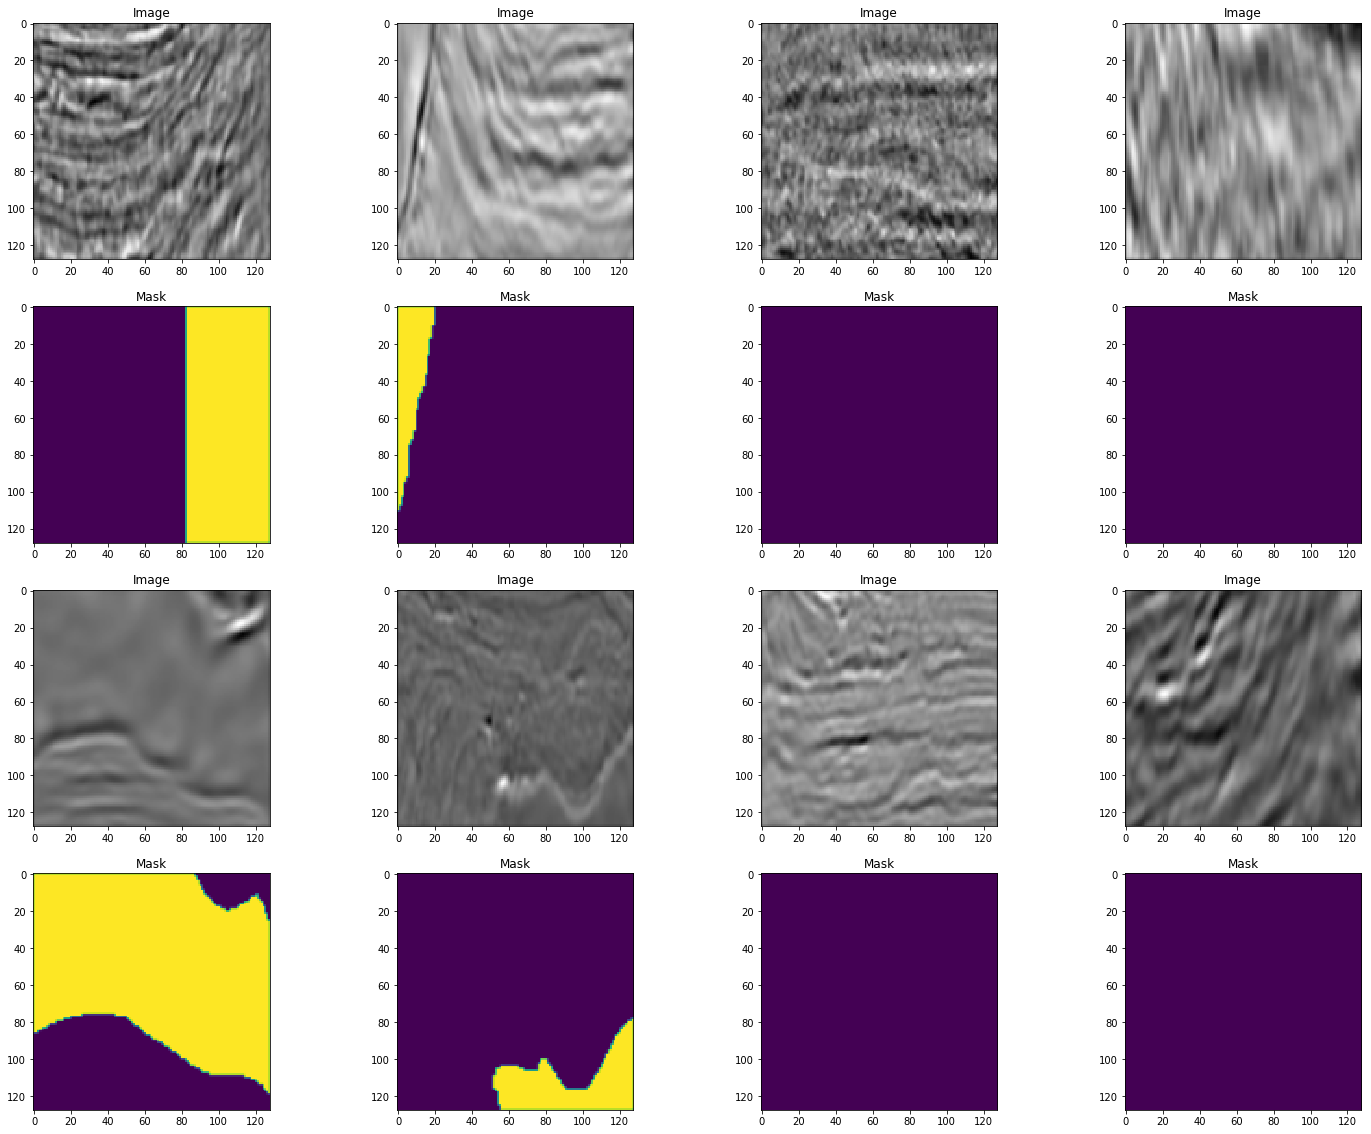

In [14]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

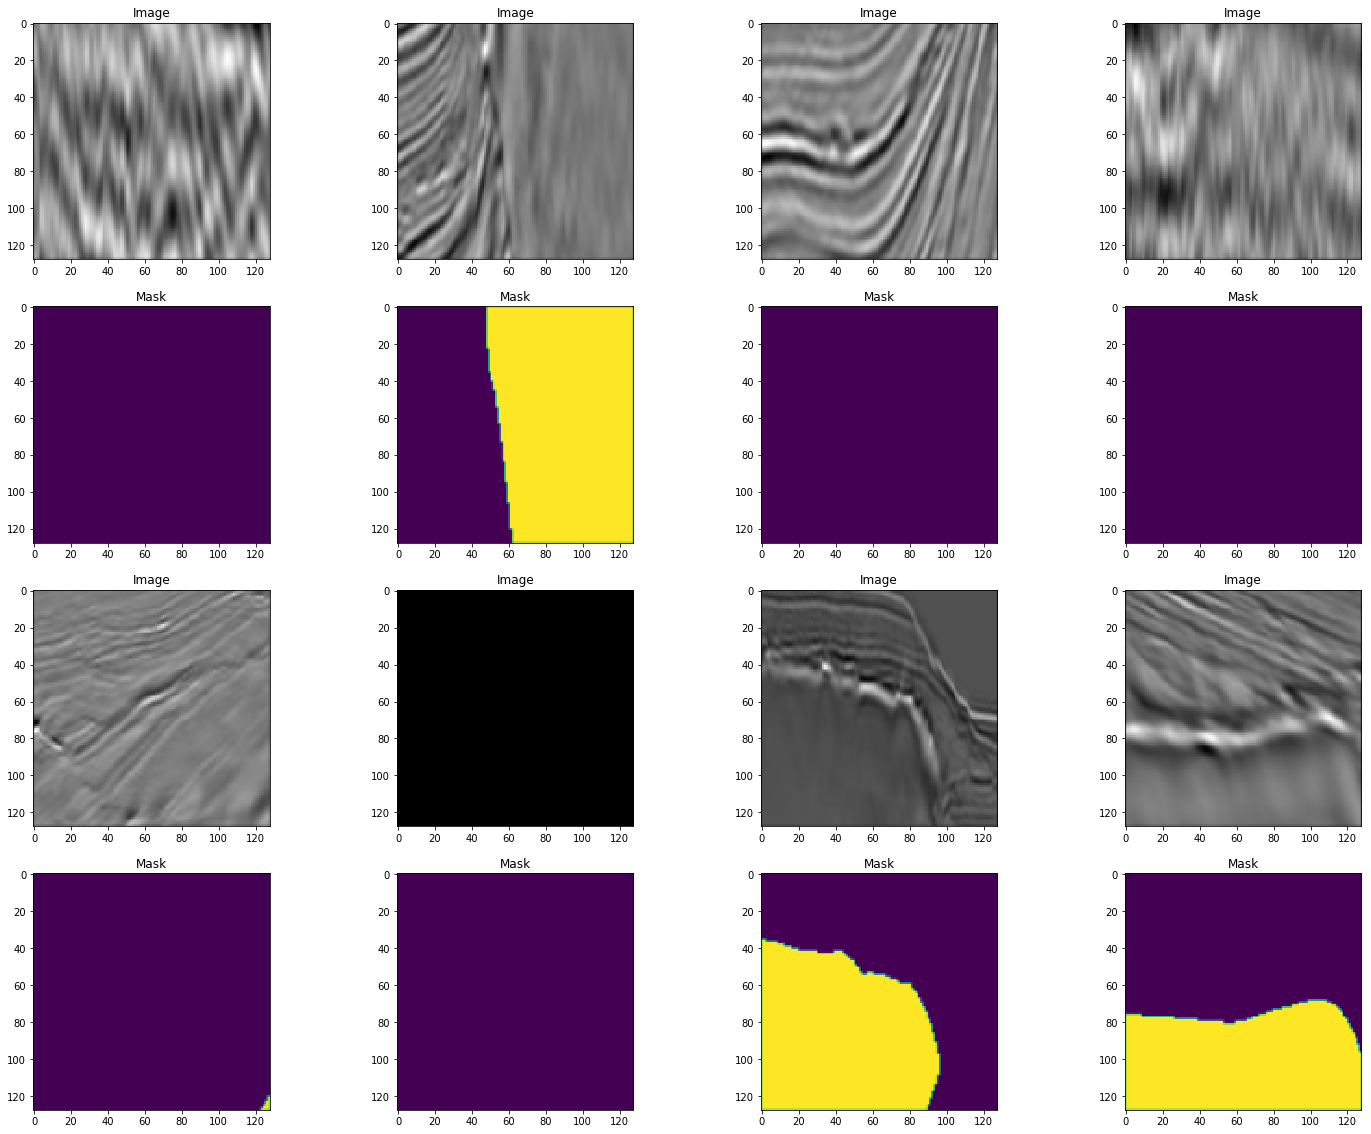

In [15]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

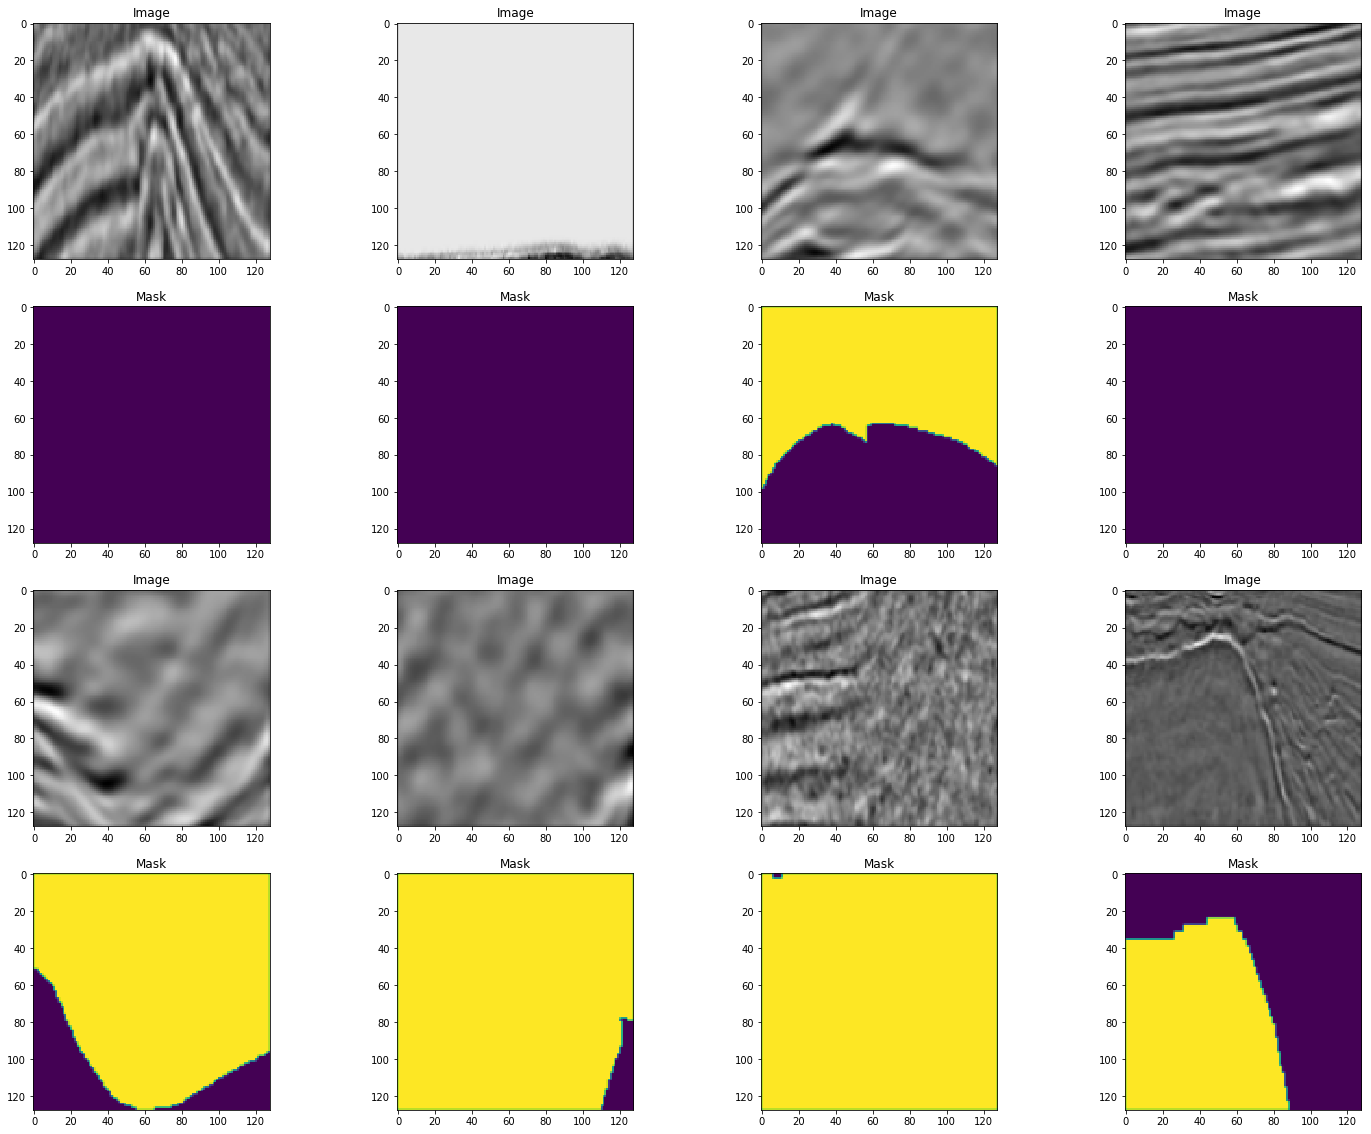

In [16]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

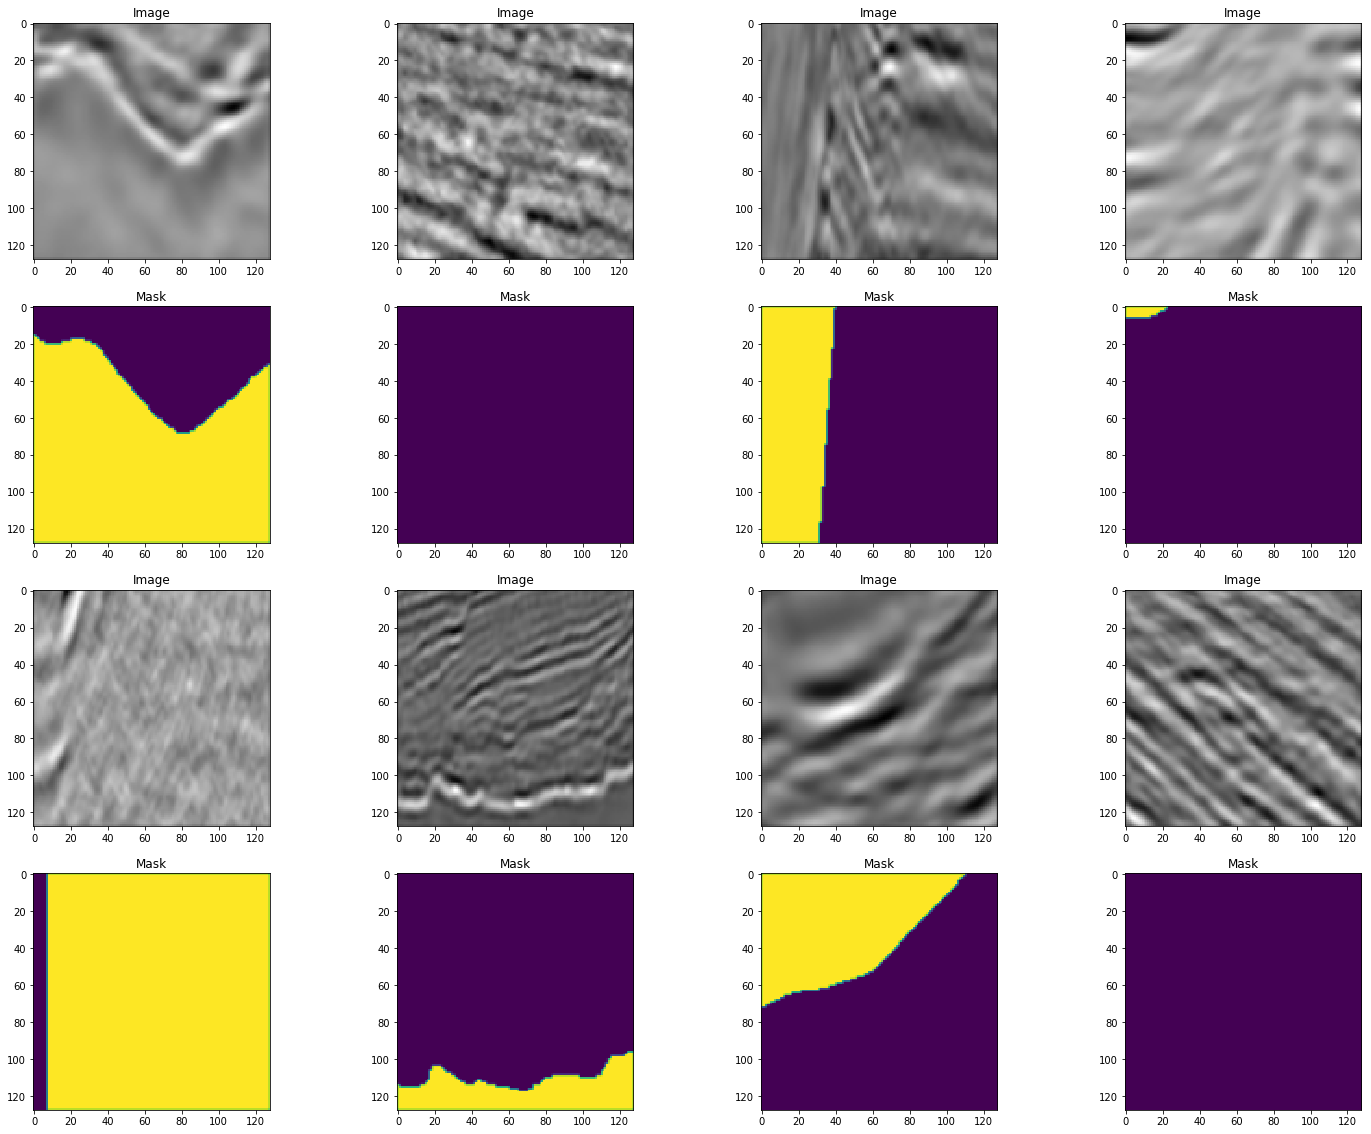

In [17]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

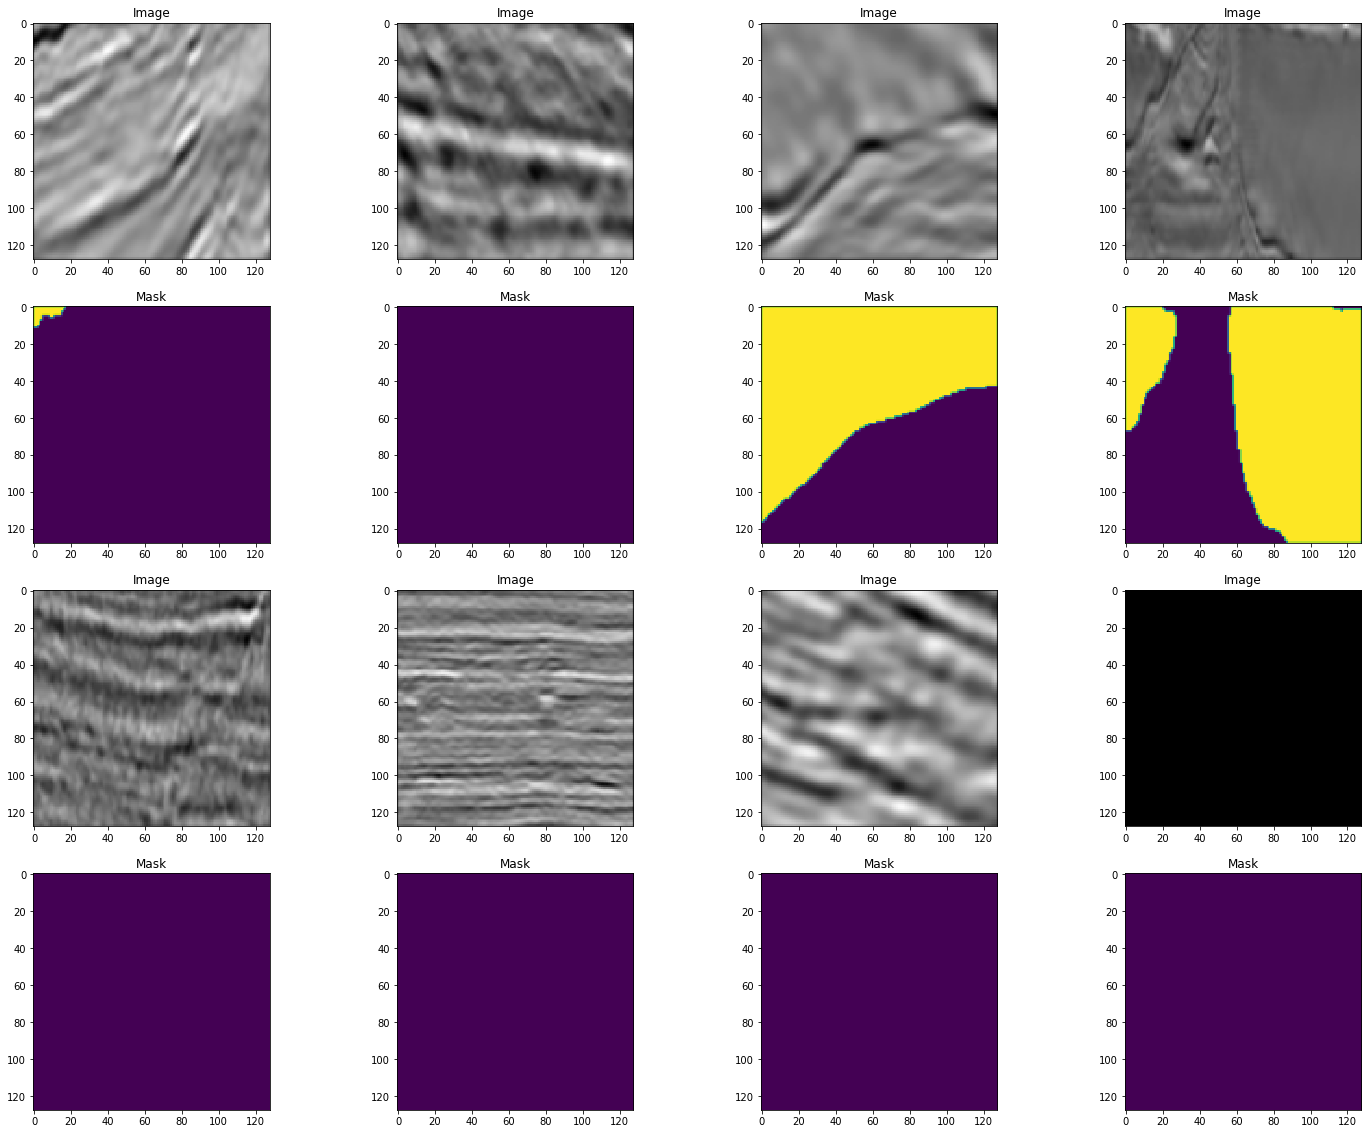

In [18]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

## 6. Create graph of U-Net

**Inspect the devices of kernel**

In [19]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13828779176528800270
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9397697552259962409
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


**Set the device to gpu if available**

In [20]:
if len(devices)>1:
    device = devices[-1].name
else:
    device = devices[0].name

**Reset the default graph**

In [21]:
tf.reset_default_graph()

**Create graph**

In [22]:
# kernel sizes of conv and deconv layers
kernel_sizes = [7,7,5,3]
# number of filters of each conv layer
conv_filters = [32,64,128,256]
# stride 
strides = 1
# max pool kernel size and strides
max_pool_kernel_size = 2
max_pool_strides = 2
# number of filters of each deconv layer 
conv_transpose_filters = [256,128,64,32]
learning_rate=0.0001*0.4
# batch size
batch_size = 200
# max iteration
max_iter = 12000
# Image Dimensions
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,IMG_HEIGHT_RESIZE,IMG_WIDTH_RESIZE,MASK_CHANNELS = 101, 101, 3, 128, 128,1
# create unet
model = unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,IMG_HEIGHT_RESIZE,IMG_WIDTH_RESIZE,MASK_CHANNELS,
             conv_filters, conv_transpose_filters, kernel_sizes, strides,
             max_pool_kernel_size, max_pool_strides, learning_rate, device, tf_rand_seed, np_rand_seed)

########################Layers of UNET########################
Tensor("conv2d/BiasAdd:0", shape=(?, 128, 128, 16), dtype=float32, device=/device:GPU:0)
Tensor("Elu:0", shape=(?, 128, 128, 16), dtype=float32, device=/device:GPU:0)
Tensor("batch_normalization/cond/Merge:0", shape=(?, 128, 128, 16), dtype=float32, device=/device:GPU:0)
Tensor("conv2d_1/BiasAdd:0", shape=(?, 128, 128, 16), dtype=float32, device=/device:GPU:0)
Tensor("Elu_1:0", shape=(?, 128, 128, 16), dtype=float32, device=/device:GPU:0)
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 128, 128, 16), dtype=float32, device=/device:GPU:0)
Tensor("max_pooling2d/MaxPool:0", shape=(?, 64, 64, 16), dtype=float32, device=/device:GPU:0)
Tensor("conv2d_2/BiasAdd:0", shape=(?, 64, 64, 32), dtype=float32, device=/device:GPU:0)
Tensor("Elu_2:0", shape=(?, 64, 64, 32), dtype=float32, device=/device:GPU:0)
Tensor("batch_normalization_2/cond/Merge:0", shape=(?, 64, 64, 32), dtype=float32, device=/device:GPU:0)
Tensor("conv2d_3/Bias

## 7. Train U-Net

**Train model**

In [23]:
# randomly generate train and validation indices
train_indices = np.random.choice(len(train_ids), round(len(train_ids)*0.95), replace=False)
validation_indices = np.array(list(set(range(len(train_ids))) - set(train_indices)))
print("Size of train set:", len(train_indices))
print("Size of validation set:", len(validation_indices))
# name of model
model_name = 'unet-salt-identification-challenge'
# arguments for train batch passed to the train method
args =(train_ids, TRAIN_IMG_DIR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX)
model.train_model(max_iter,batch_size,
                  train_indices,validation_indices, train_ids,
                  model_dir, model_name, generate_batch,*args)

Size of train set: 3800
Size of validation set: 200


[100%]||(train_cost:  0.615)(valid_cost:  0.622)(best_valid_cost:  0.617)(time_elapsed:    266mins)


**Plot of cost vs iterations**

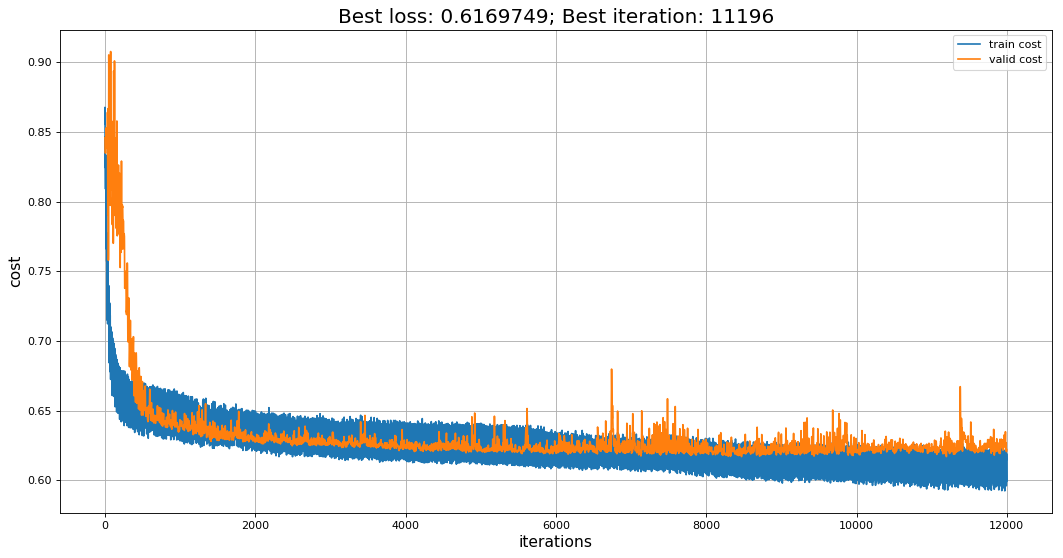

In [24]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(model.train_cost, label = 'train cost')
plt.plot(model.valid_cost, label = 'valid cost')
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('cost', fontsize = 14)
plt.title("Best loss: "+str(model.best_cost)+"; Best iteration: "+str(model.best_iteration),fontsize = 18)
plt.legend()
plt.grid()
plt.show()

## 8. Visualize sample predicted and corresponding original masks

**Compute predicted masks for validation set**

In [25]:
# generate batch of images and masks for validation set 
image_validation, mask_validation =  generate_batch(validation_indices, train_ids, TRAIN_IMG_DIR, 
                                                    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX, train_set=True)
# feed dict for validation set
feed_dict_validation =  {model.X: image_validation.astype(np.float32), model.Y: mask_validation.astype(np.float32), 
                         model.training: False, model.cond: np.array([0,0,0])}
# compute the predicted mask of the validation set
with tf.Session() as sess:
    # restore the best model
    model_path = model_dir+model_name+"-"+str(model.best_iteration)
    model.saver.restore(sess, model_path)
    # compute predicted masks
    mask_predicted = sess.run(model.Y_, feed_dict=feed_dict_validation)

INFO:tensorflow:Restoring parameters from ./model_files/unet-salt-identification-challenge-11196


**A function to plot sample predicted and original masks**

In [26]:
def plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices,treshold):
    
    '''
    A function to plot masks and corresponding predicted masks
    '''
    # squeeze arrays containing masks and predicted masks of validation set
    mask_predicted_squeezed = np.squeeze(mask_predicted[indices])
    mask_validation_squeezed = np.squeeze(mask_validation[indices].astype(np.float32))
    # binirize predicted masks
    mask_predicted_squeezed = binirize_mask(mask_predicted_squeezed, threshold = treshold)
    # plot the masks and corresponding predicted masks
    matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
    plt.subplot(4,4,1)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[0])
    plt.subplot(4,4,1+4)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[0])
    plt.subplot(4,4,2)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[1])
    plt.subplot(4,4,2+4)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[1].astype(np.uint8))
    plt.subplot(4,4,3)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[2].astype(np.uint8))
    plt.subplot(4,4,3+4)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[2].astype(np.uint8))
    plt.subplot(4,4,4)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[3].astype(np.uint8))
    plt.subplot(4,4,4+4)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[3].astype(np.uint8))
    plt.subplot(4,4,9)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[4].astype(np.uint8))
    plt.subplot(4,4,1+12)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[4].astype(np.uint8))
    plt.subplot(4,4,10)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[5].astype(np.uint8))
    plt.subplot(4,4,2+12)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[5].astype(np.uint8))
    plt.subplot(4,4,11)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[6].astype(np.uint8))
    plt.subplot(4,4,3+12)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[6].astype(np.uint8))
    plt.subplot(4,4,12)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[7].astype(np.uint8))
    plt.subplot(4,4,4+12)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[7].astype(np.uint8))
    plt.show()

**Generate indices and plot sample masks and predicted masks**

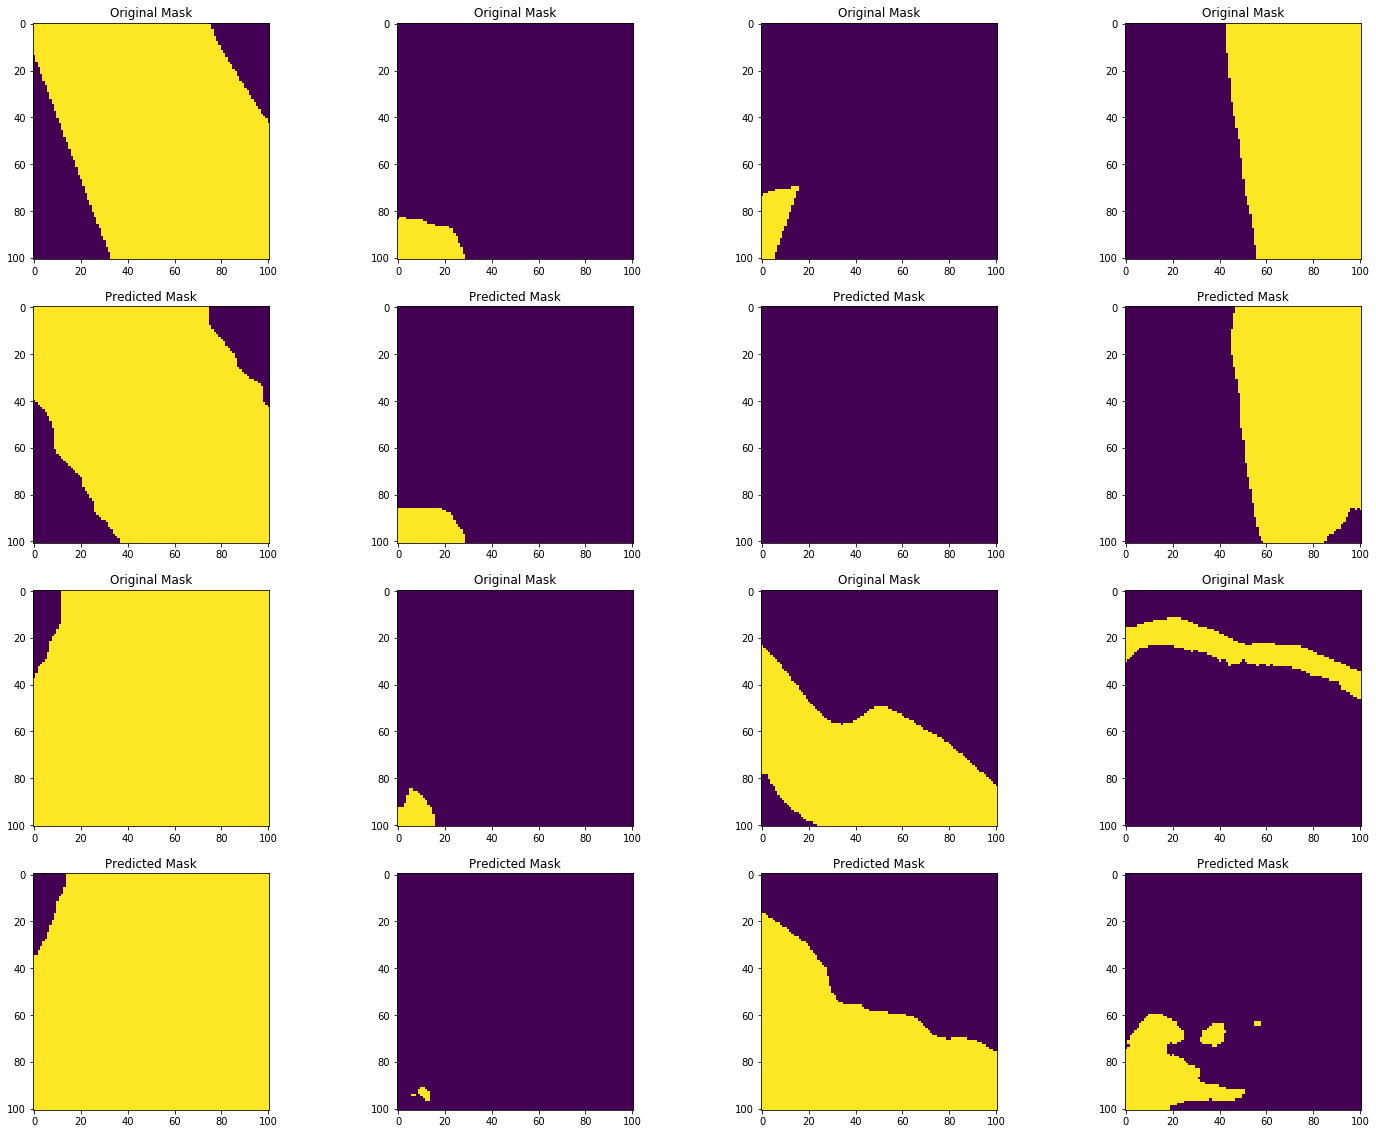

In [27]:
indices = np.array(list(range(0,8)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

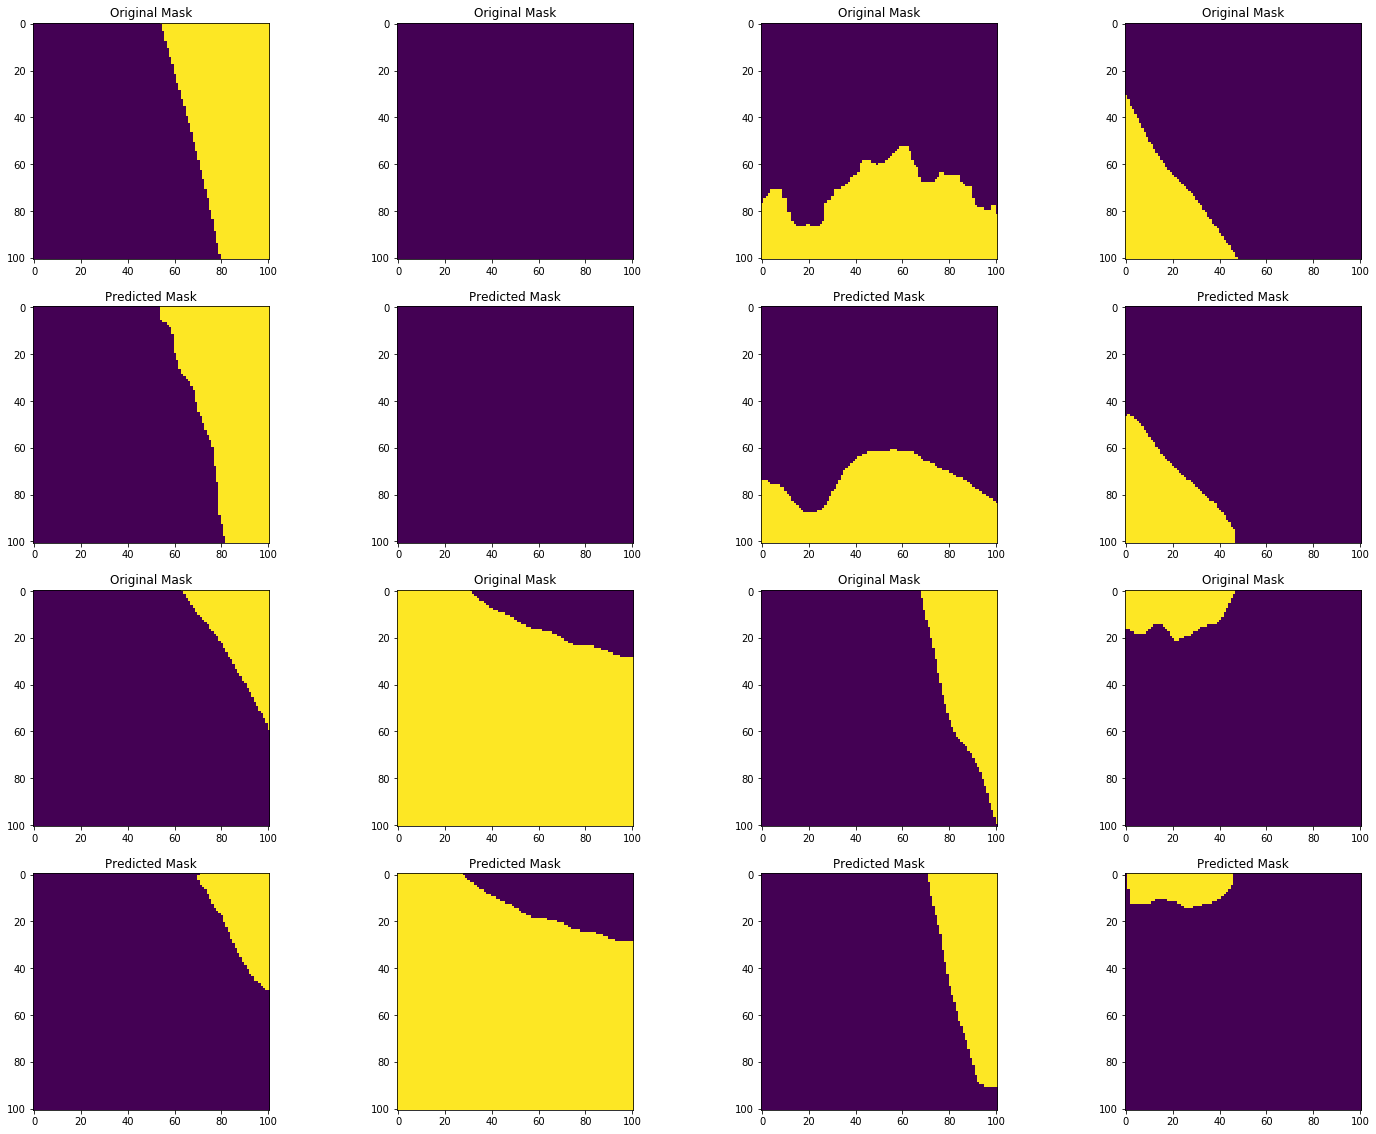

In [28]:
indices = np.array(list(range(8,16)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

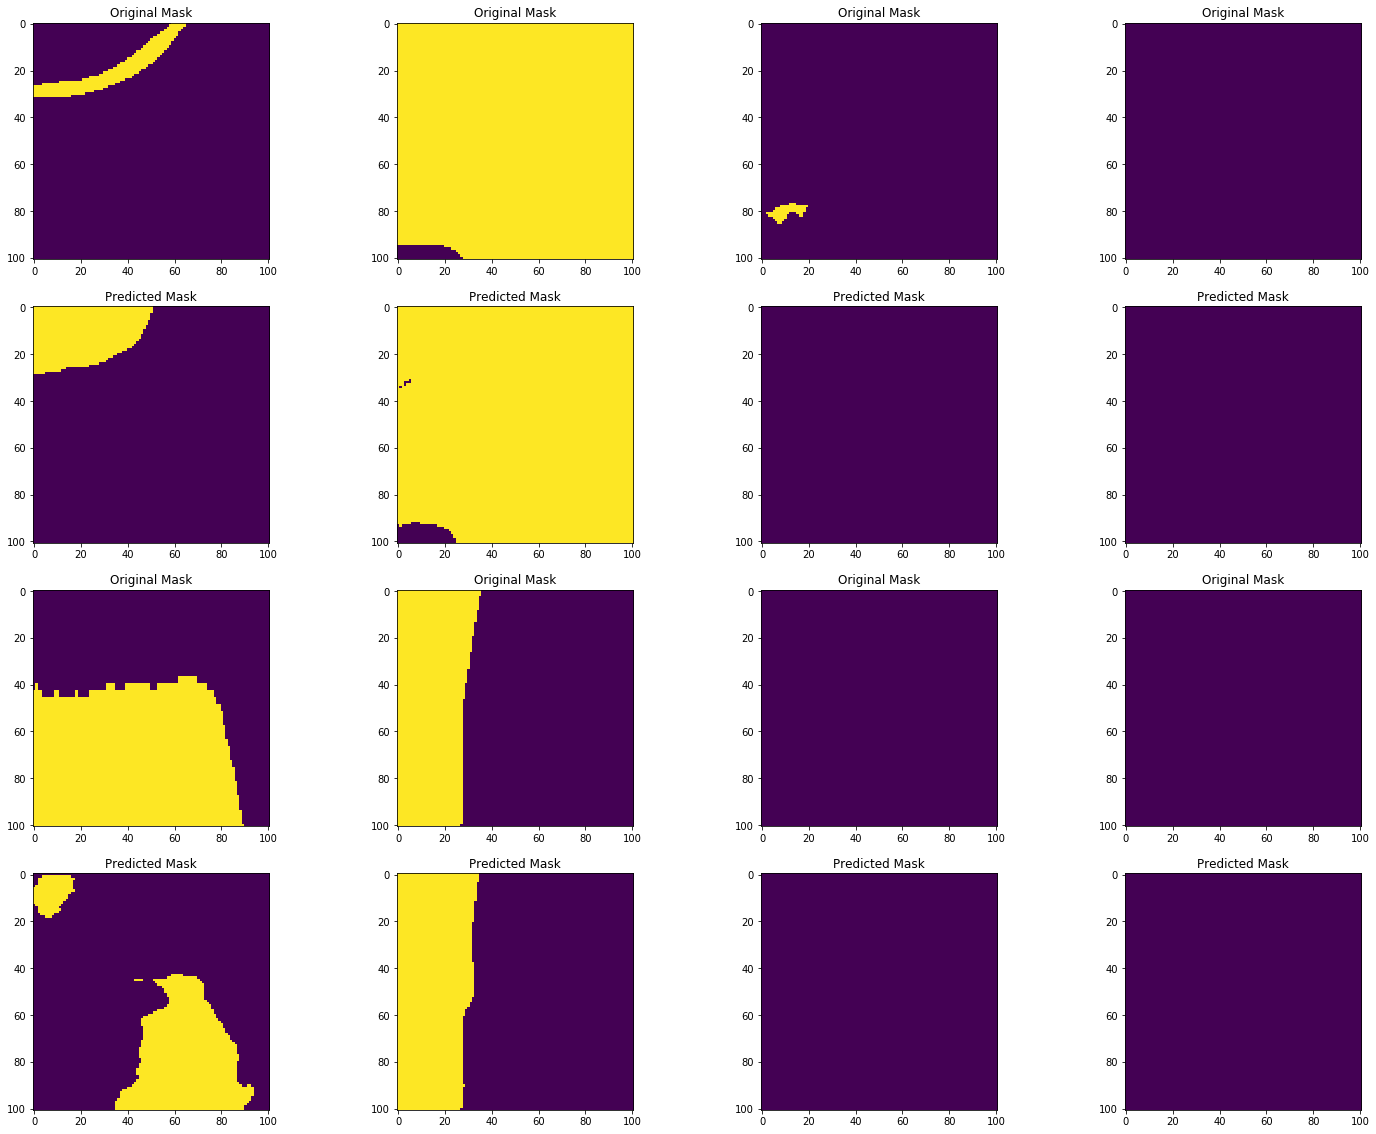

In [29]:
indices = np.array(list(range(16,24)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

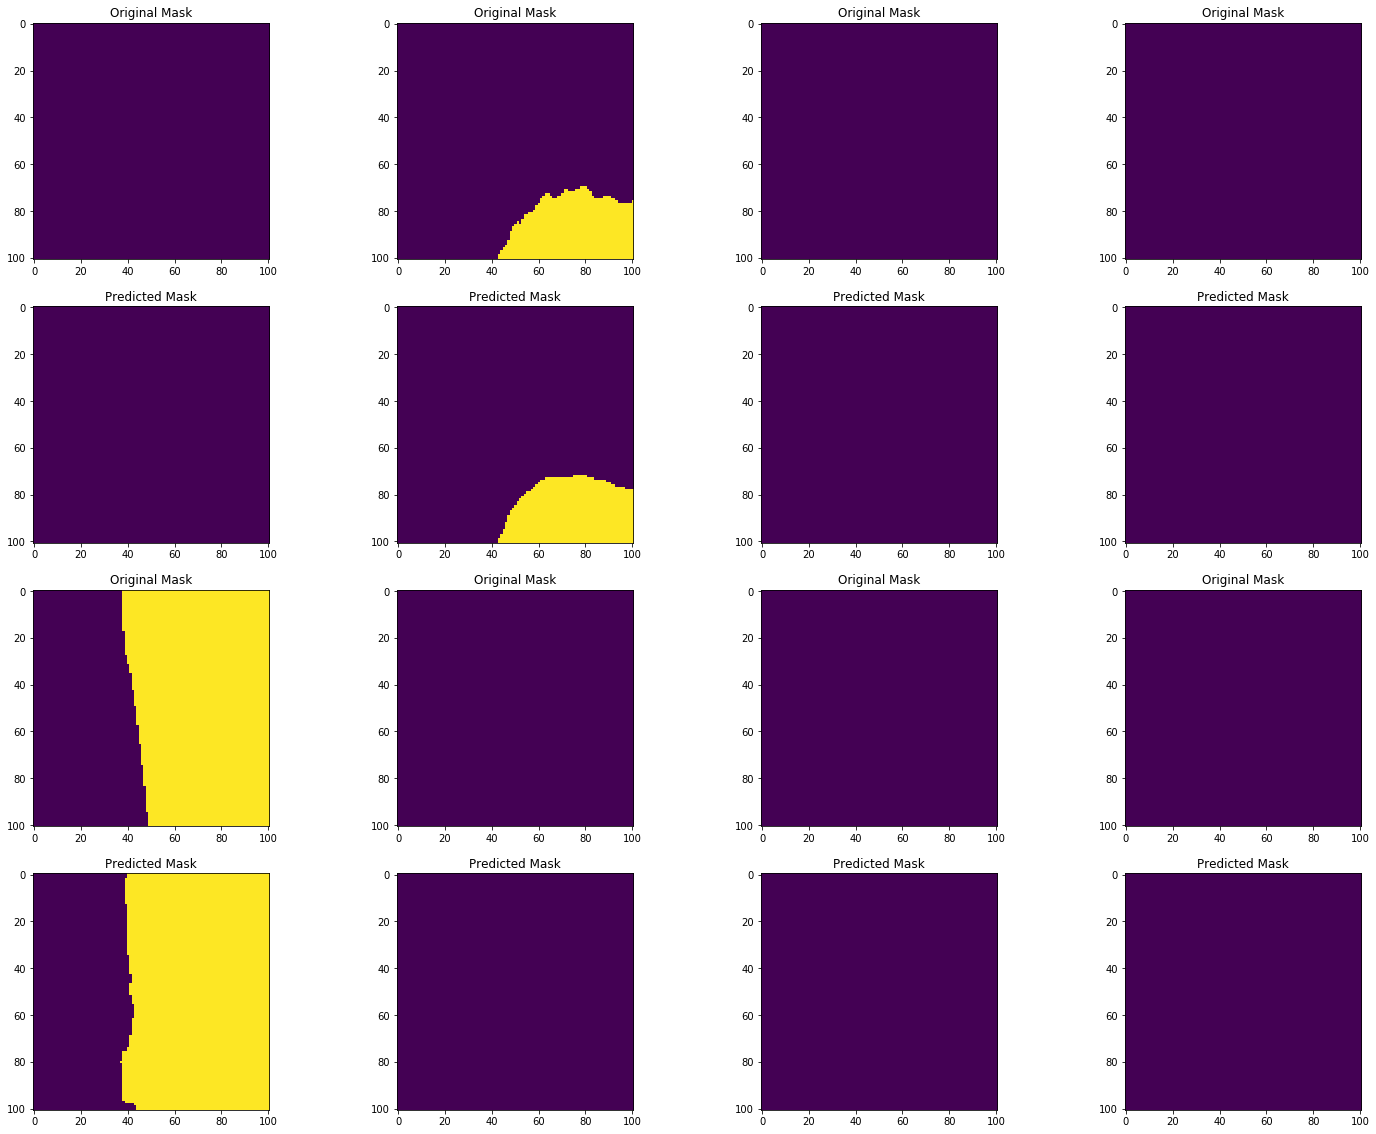

In [30]:
indices = np.array(list(range(24,32)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

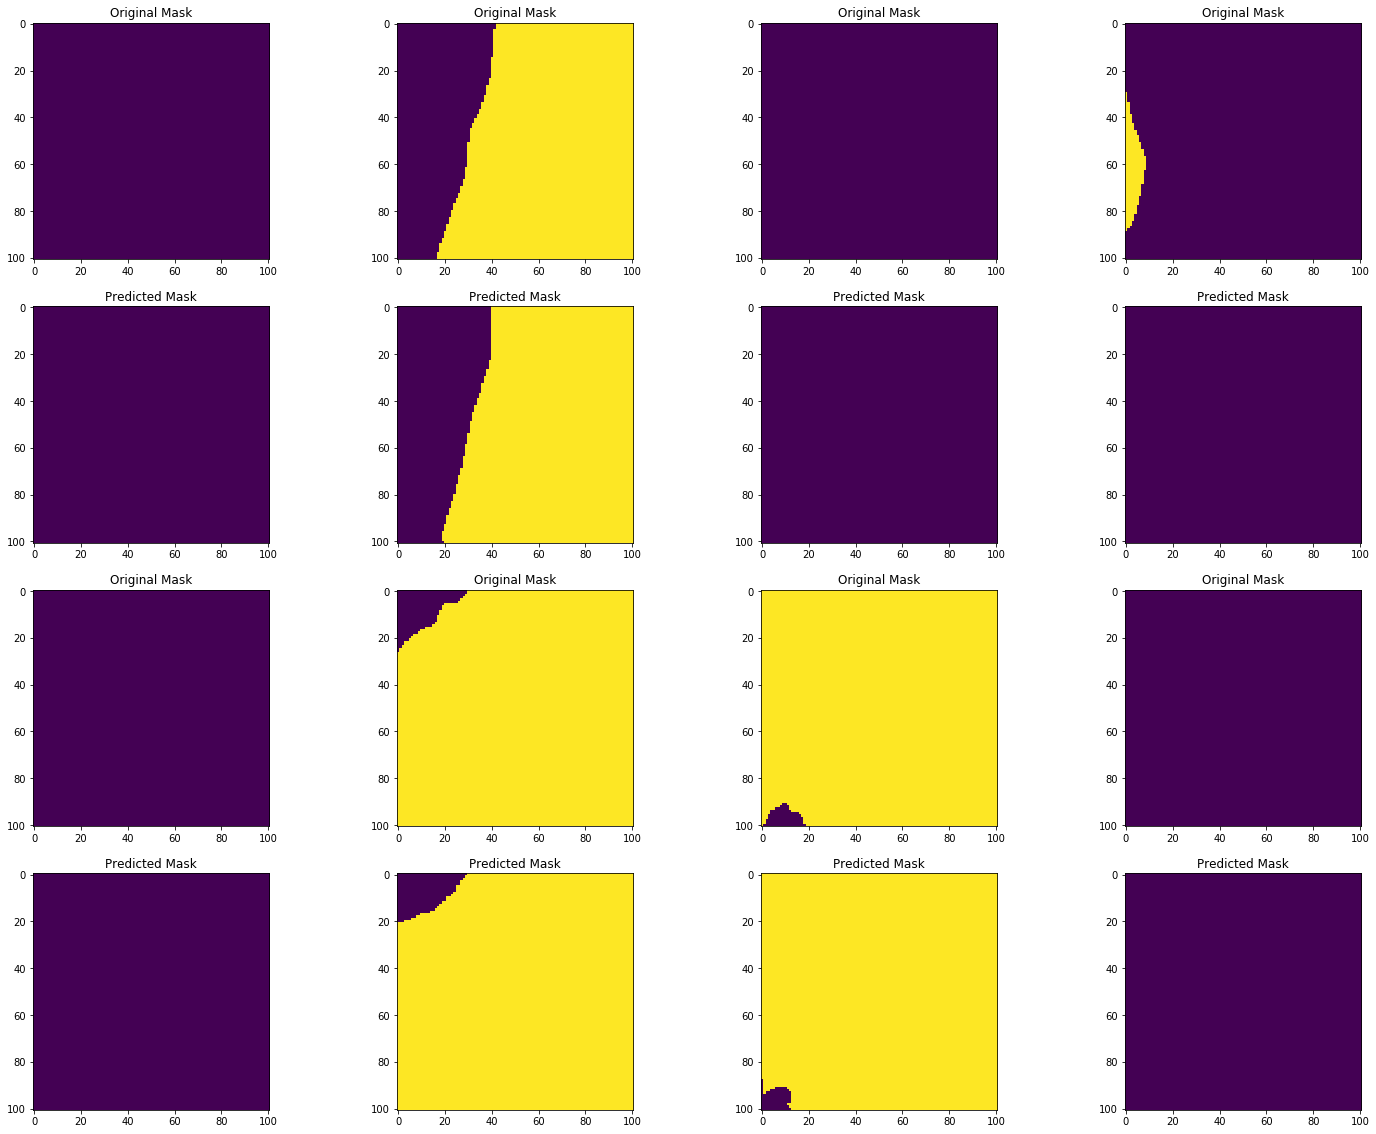

In [31]:
indices = np.array(list(range(32,40)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

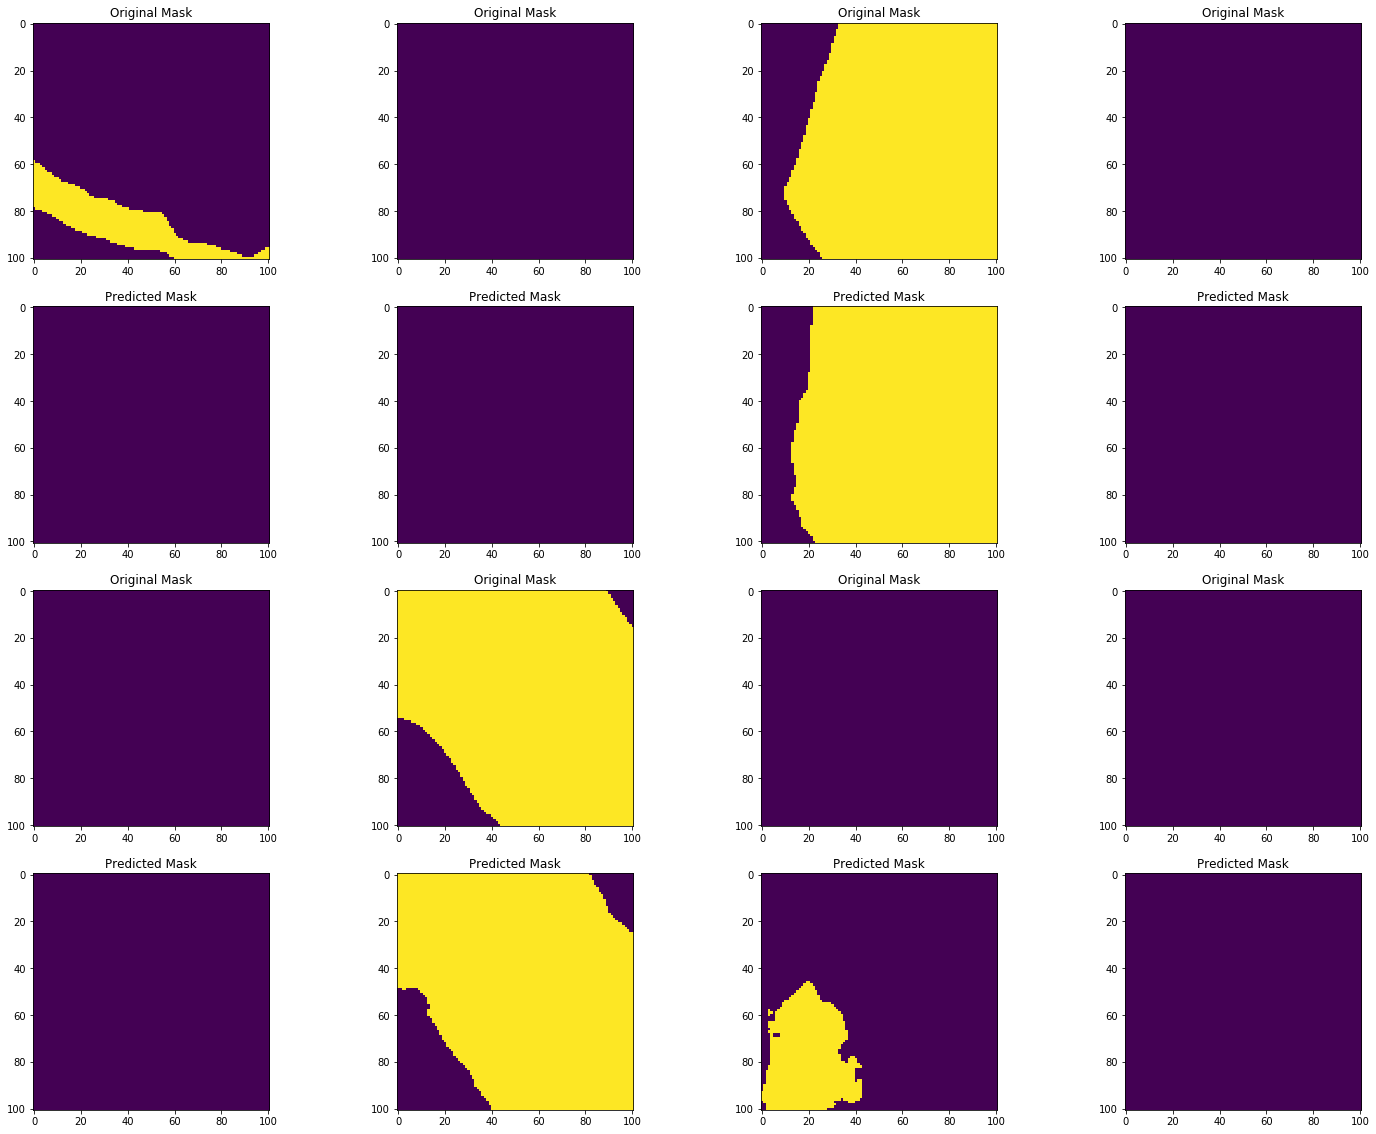

In [32]:
indices = np.array(list(range(40,48)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

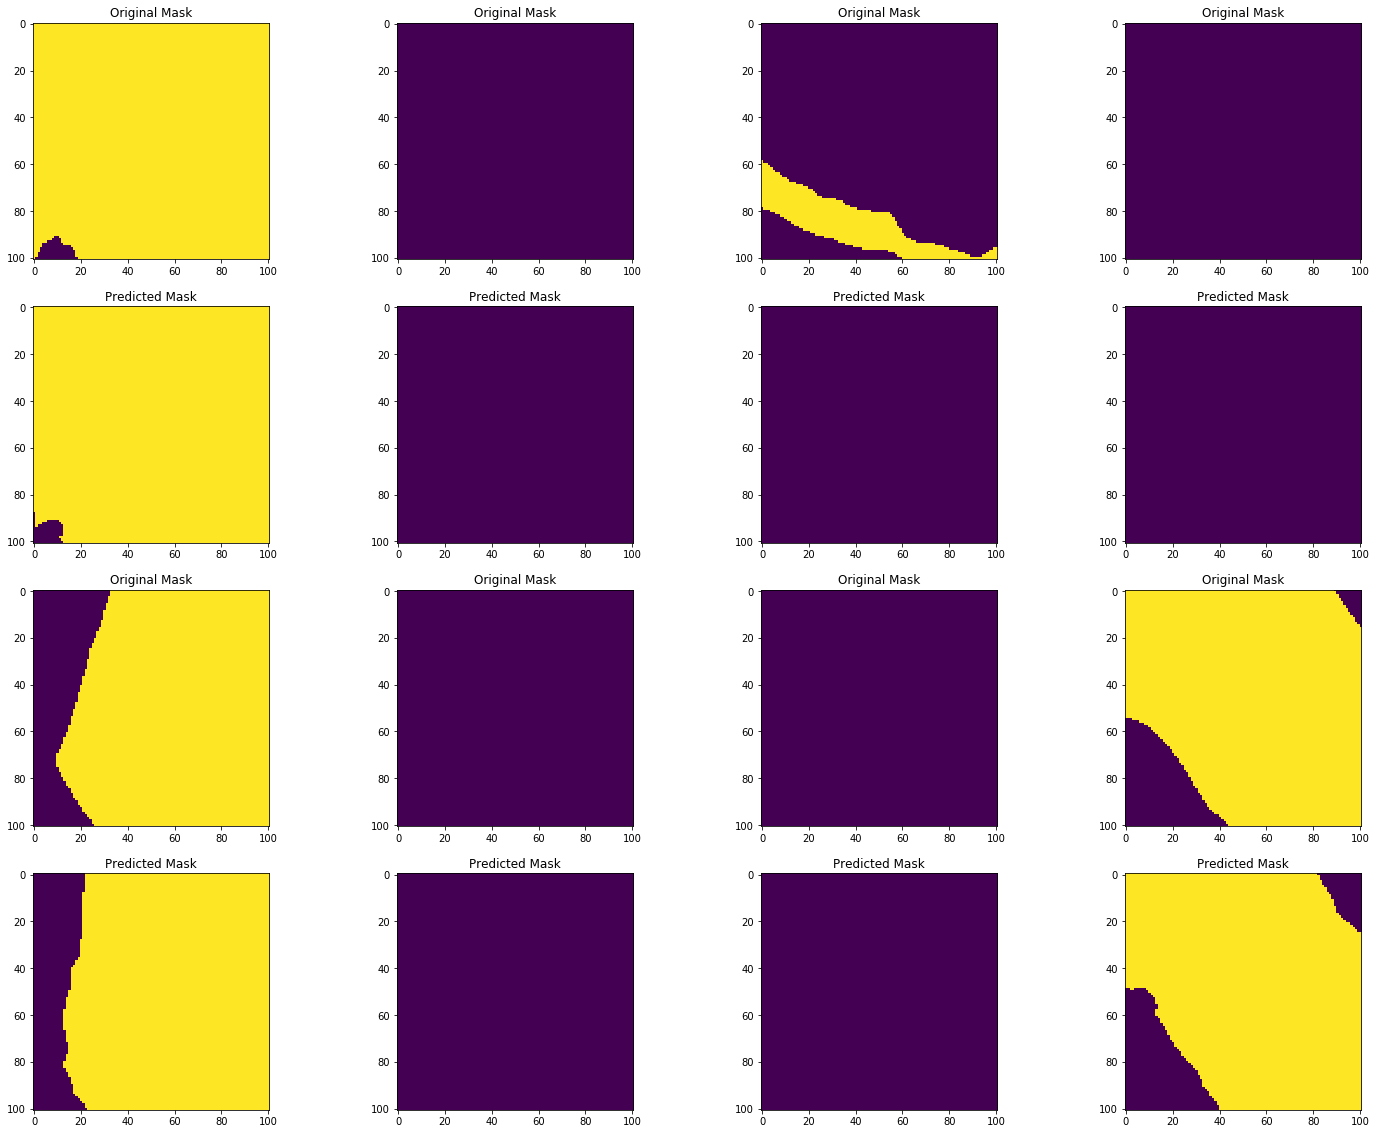

In [33]:
indices = np.array(list(range(38,56)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

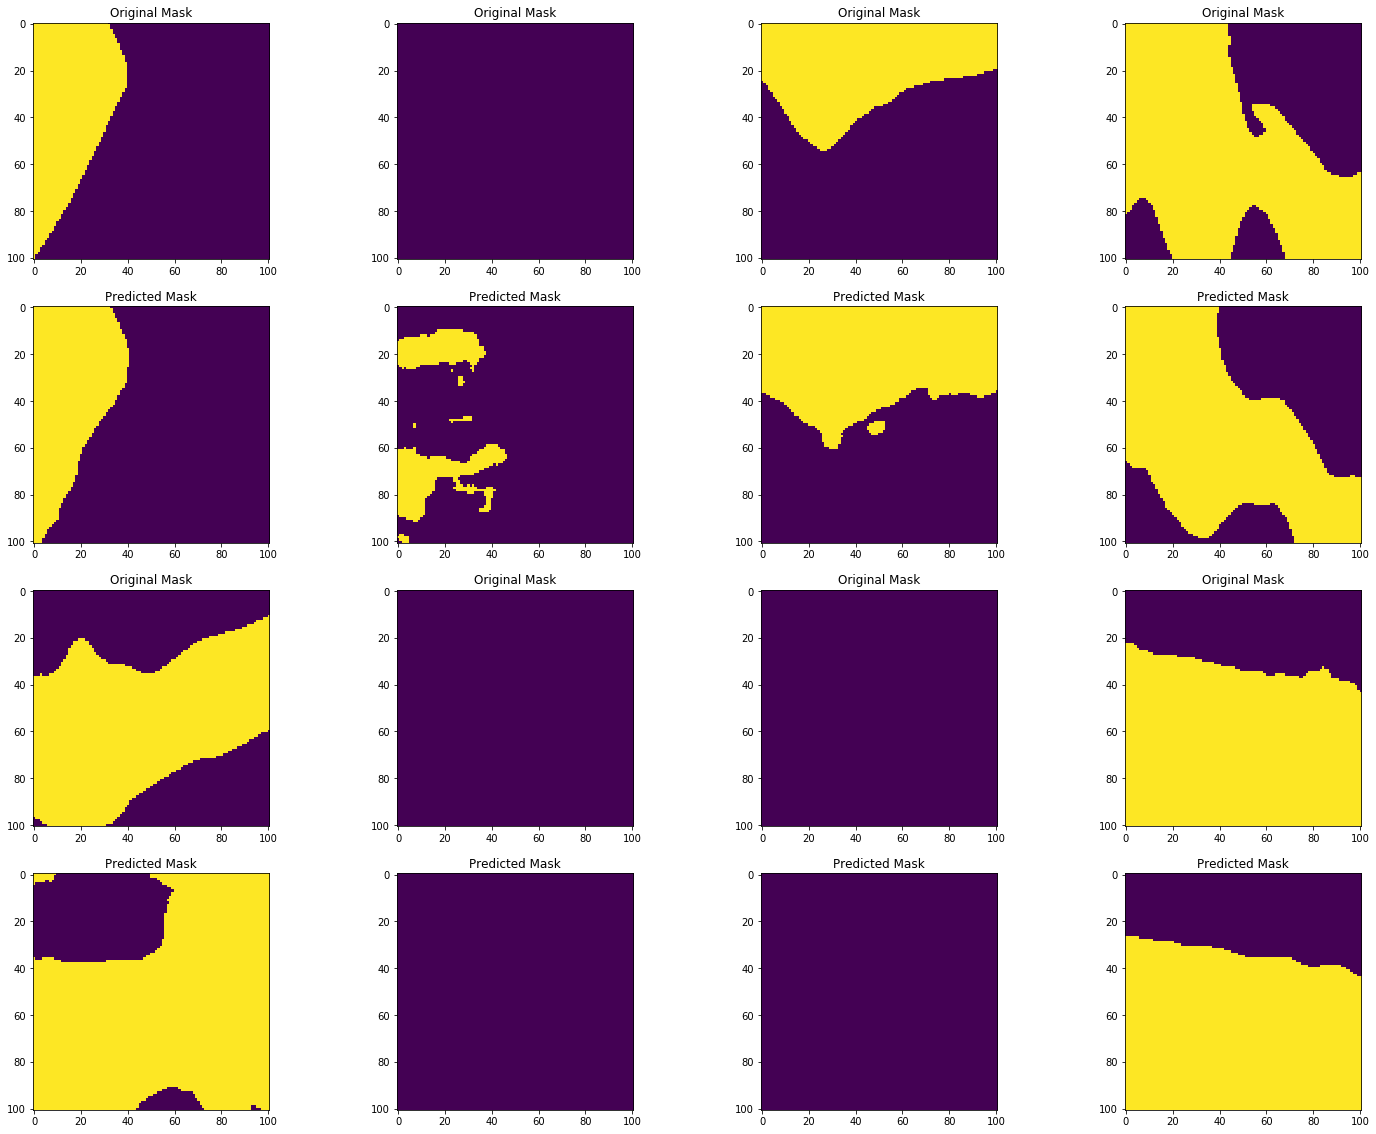

In [34]:
indices = np.array(list(range(56,64)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

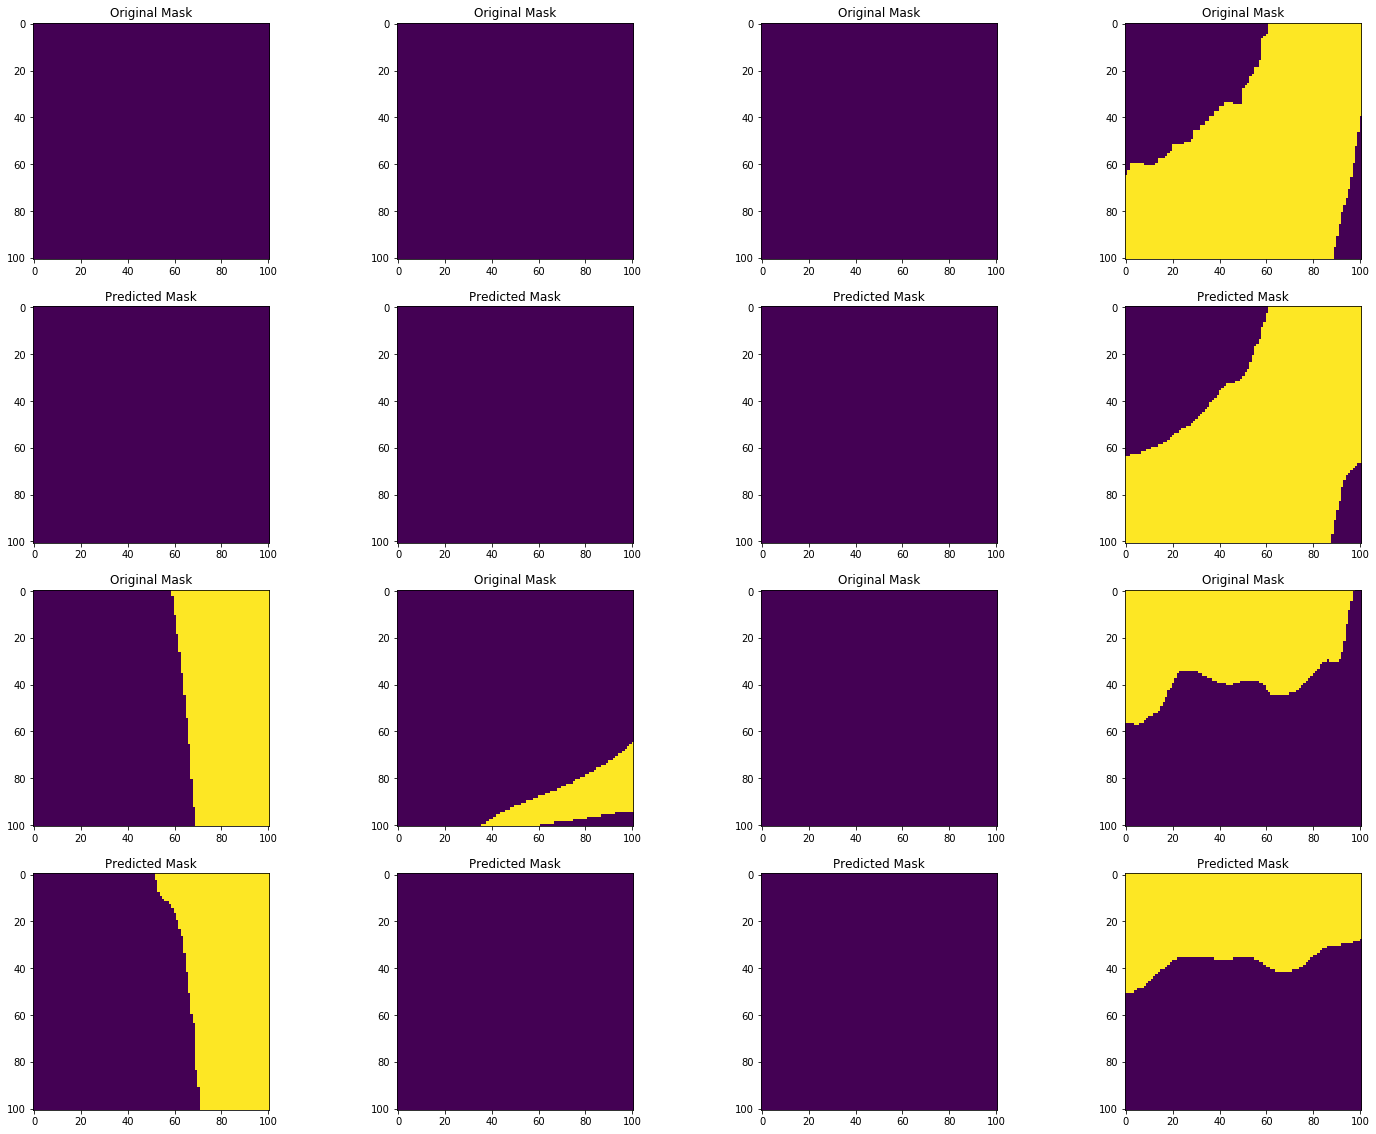

In [35]:
indices = np.array(list(range(64,72)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

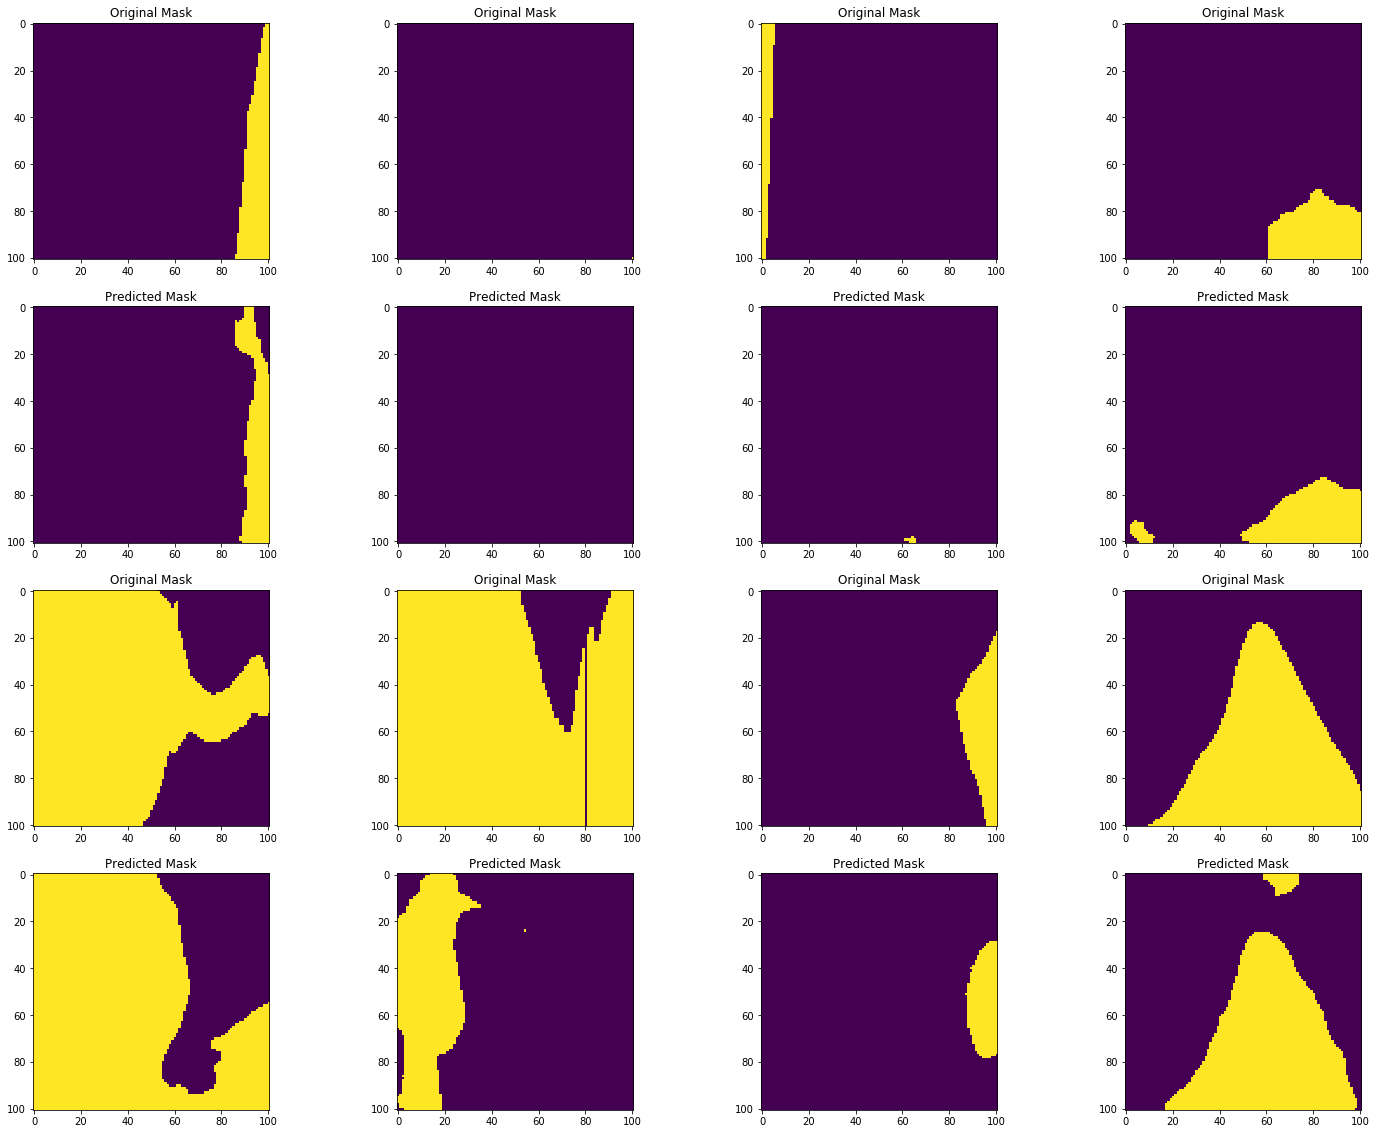

In [36]:
indices = np.array(list(range(72,80)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

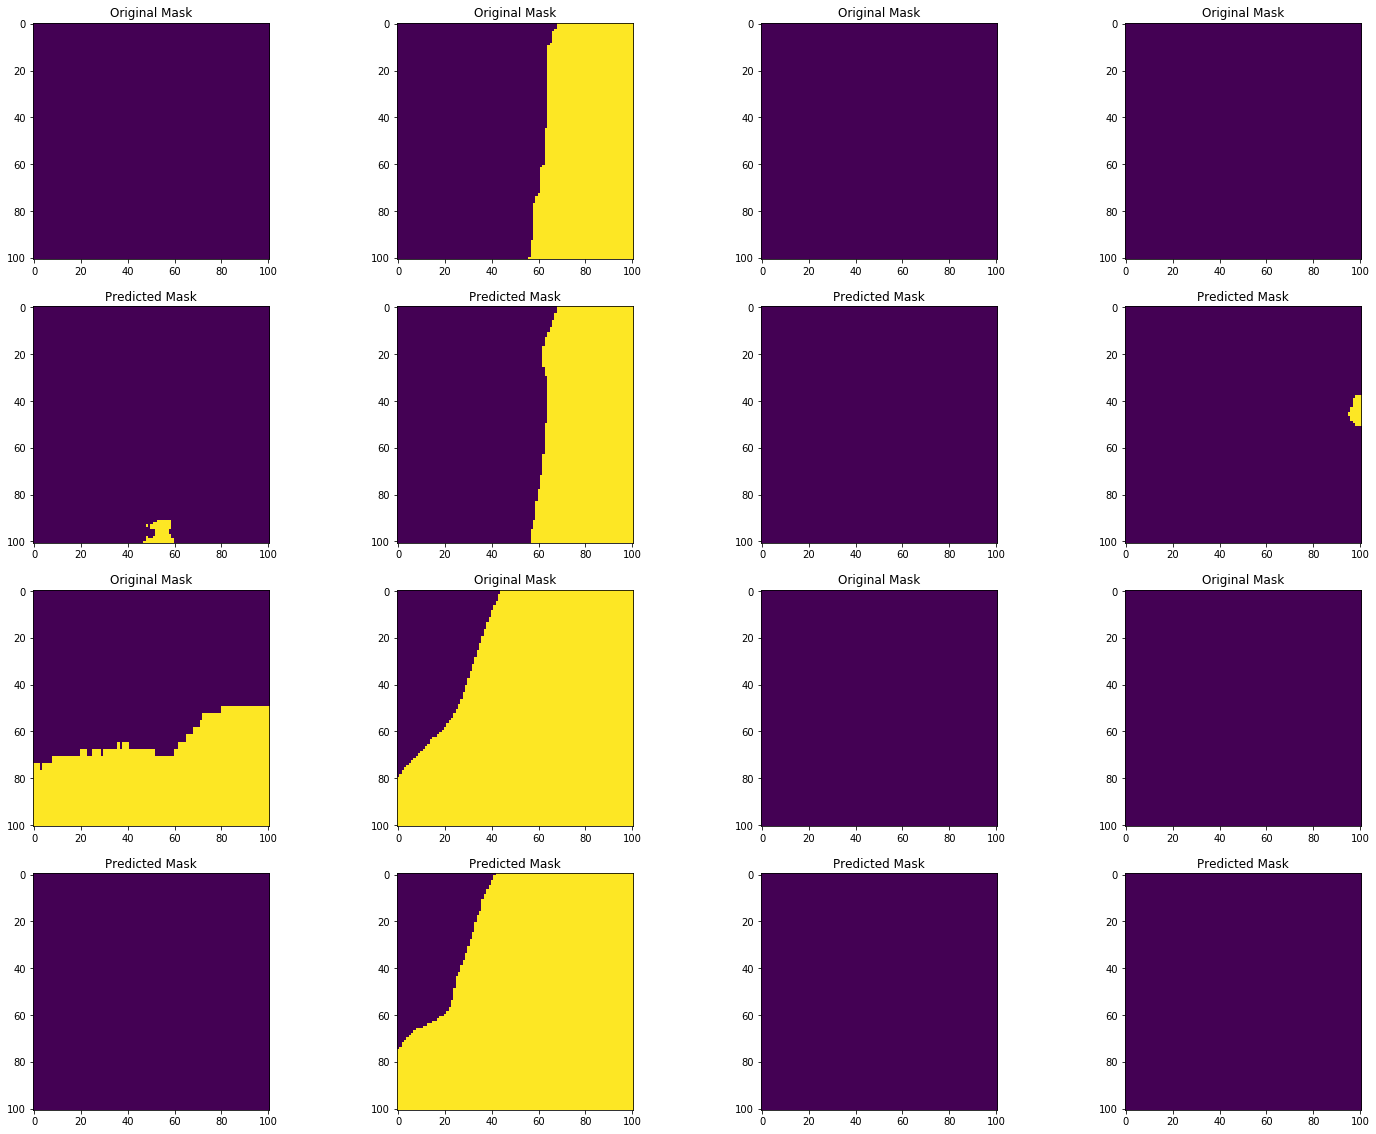

In [37]:
indices = np.array(list(range(80,88)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

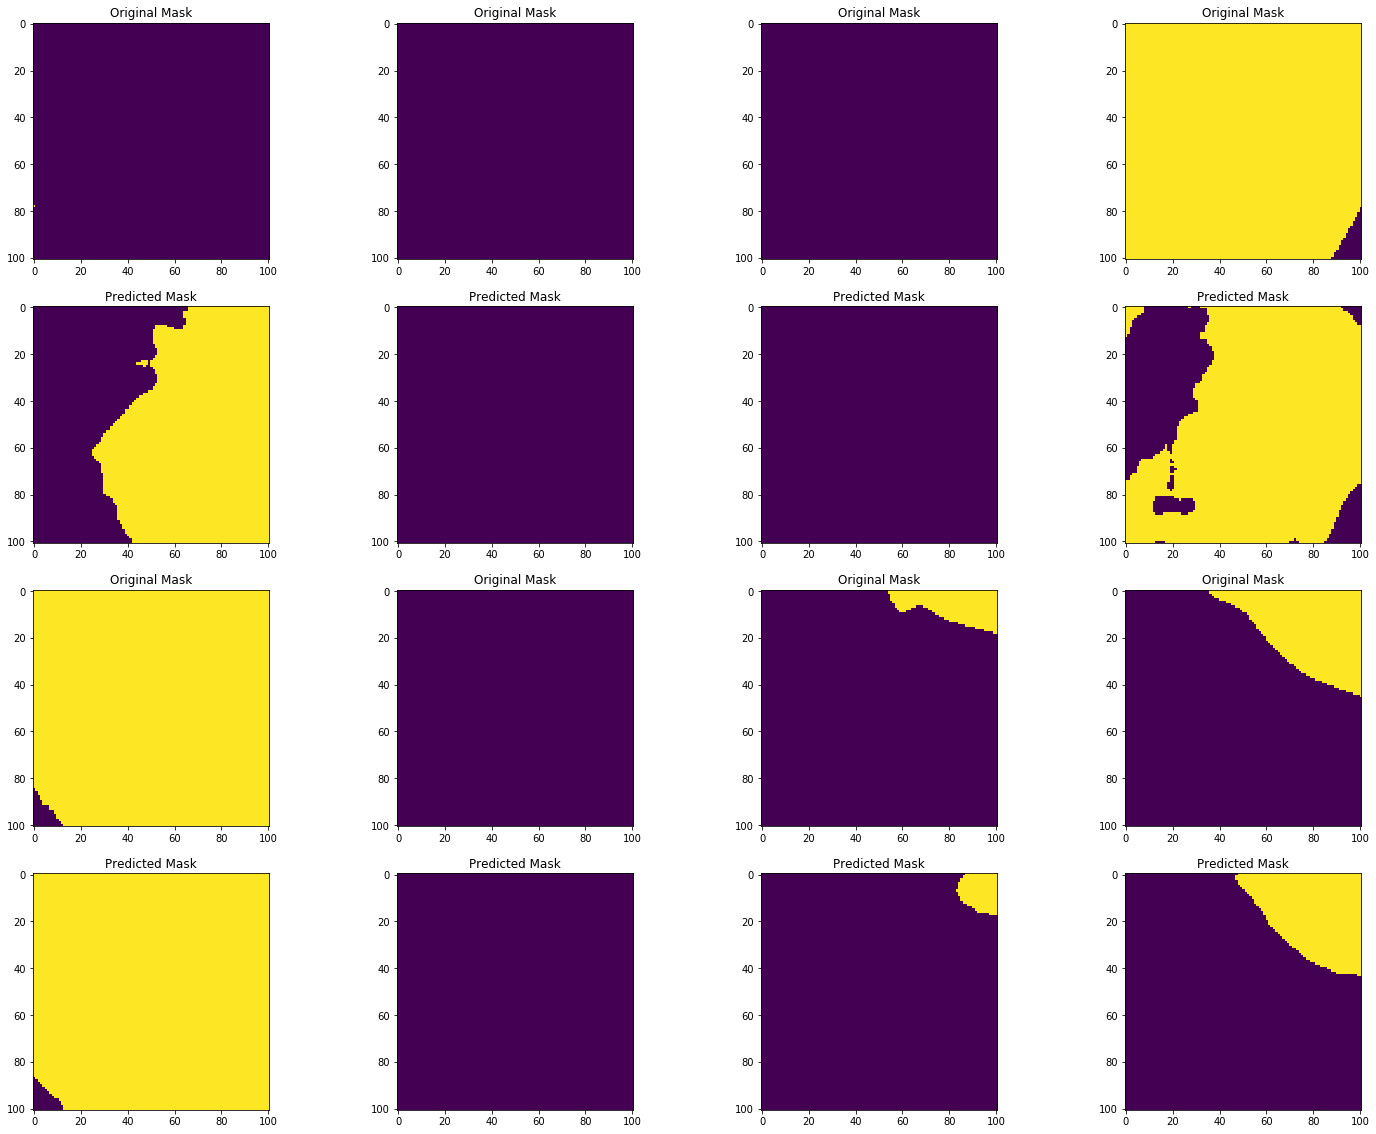

In [38]:
indices = np.array(list(range(88,96)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

## 9. Analyse Results

**Print results**

In [39]:
print("Best validation cost:", model.best_cost)
print("Time to reach best validation cost:", model.best_time, "mins")
print("#iterations to reach best validation cost:", model.best_iteration)

Best validation cost: 0.6169749
Time to reach best validation cost: 248.68815035025278 mins
#iterations to reach best validation cost: 11196


**Compute intersection of union on validation set**

In [40]:
with tf.Session() as sess:
    # restore the best model
    model_path = model_dir+model_name+"-"+str(model.best_iteration)
    model.saver.restore(sess, model_path)
    # compute intersection of union on validation set
    intersection_of_union = sess.run(model.iou, feed_dict=feed_dict_validation)
print("IoU on validation set:",intersection_of_union)

INFO:tensorflow:Restoring parameters from ./model_files/unet-salt-identification-challenge-11196
IoU on validation set: 0.6825


**Create submission file**

In [41]:
n_folds = 100
threshold = 0.5
submission_file = "submission.csv"
args =(test_ids, TEST_IMG_DIR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX)
model.compute_predictions(model_path, n_folds,test_ids, TEST_IMG_DIR,
                          threshold, submission_dir, submission_file,
                          generate_batch, IMG_HEIGHT, IMG_WIDTH, *args)

INFO:tensorflow:Restoring parameters from ./model_files/unet-salt-identification-challenge-11196


[100%]|####################################|(number_of_folds_completed:    100)
